In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math, scipy, skimage, os
import matplotlib as mpl
import seaborn as sns

mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 7
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42

mpl.rcParams['axes.linewidth'] = 0.5
mpl.rcParams['xtick.major.width'] = 0.5
mpl.rcParams['ytick.major.width'] = 0.5
mpl.rcParams['xtick.minor.width'] = 0.5
mpl.rcParams['ytick.minor.width'] = 0.5
mpl.rcParams['xtick.major.size'] = 2.5
mpl.rcParams['ytick.major.size'] = 2.5

In [2]:
# pivlab rearrangement and divergence calculation

def piv_lab_rearrange(folder, pixel_size, t_interval, every = None):
        
    data_files = []

    for i in os.listdir(folder):
        if '.txt' in i and 'PIVlab' in i:
            data_files.append(i)
    
    frame_num = len(data_files)
    
    x2 = [[]]*frame_num
    y2 = [[]]*frame_num
    u2 = [[]]*frame_num
    v2 = [[]]*frame_num
    
    with open(folder + '/PIVlab_0001.txt') as f:
        first_line = f.readline()
    if first_line[:6] == "x [px]":
        header = 0
    else:
        header = 2

    for frame in range(1,frame_num+1):
        
        if frame < 10:
            frame_name = '000' + str(frame)
        elif frame >=10 and frame < 100:
            frame_name = '00' + str(frame)
        elif frame >= 100:
            frame_name = '0' + str(frame)
            
        data = pd.read_csv(folder + '/PIVlab_'+ frame_name + '.txt',
                            sep=",", header=header)#.fillna(0)
        x2[frame-1] = np.array(data['x [px]'])
        y2[frame-1] = np.array(data['y [px]'])
        u2[frame-1] = np.array(data['u [px/frame]'])
        v2[frame-1] = np.array(data['v [px/frame]'])
        # u2[frame-1][np.isnan(u2[frame-1])] = 0
        # v2[frame-1][np.isnan(v2[frame-1])] = 0
        
    x2 = np.array(x2)
    y2 = np.array(y2)
    u2 = np.array(u2) * pixel_size / t_interval 
    v2 = np.array(v2) * pixel_size / t_interval 
    
    # x3y3 shape: x*y    
    x3 = np.unique(x2)
    y3 = np.unique(y2)    
    
    # xy shape: x, y
    # uv shape: t, x, y
    # vel shape: t, x, y
    x = x2[0].reshape(len(x3), len(y3))
    y = y2[0].reshape(len(x3), len(y3))
    u = u2.reshape(frame_num, len(x3), len(y3))
    v = v2.reshape(frame_num, len(x3), len(y3))
    
    # x2y2u2v2vel2 shape: t, x*y
    u2 = np.nan_to_num(u2)
    v2 = np.nan_to_num(v2)
    
    vel = np.sqrt(v**2 + u**2)
    vel2 = np.nan_to_num(vel.reshape(frame_num, len(y3)*len(x3)))
    
    class Piv_data_rearranged:
        def __init__(self, t_interval, frame_num, x, y, u, v, vel, x2, y2, u2, v2, vel2, x3, y3):
            self.t = np.arange(frame_num-1) * t_interval
            self.f = frame_num
            self.x, self.y, self.u, self.v = x,y,u,v
            self.x2, self.y2, self.u2, self.v2 = x2,y2,u2,v2
            self.x3, self.y3 = x3, y3
            self.vel, self.vel2 = vel, vel2
        
    data = Piv_data_rearranged(t_interval, frame_num, x, y, u, v, vel, x2, y2, u2, v2, vel2, x3, y3)
#     print('shape of [ x y ]: x, y' + '\n' +
#           'shape of [ u v vel ]: t, x, y' + '\n' +
#           'shape of [ x2 y2 u2 v2 vel2 ]: t, x*y' + '\n'
#           'shape of [ x3 y3 ]: x*y')
    
    return data

def get_the_differential(array, interp_scale):
    return np.gradient(array)

# def get_the_differential(array, times):
    
#     array_length = len(array)
#     x_old = np.arange(array_length)
#     x_new = np.arange(0, array_length-1+1/times, 1/times)
    
#     from scipy import interpolate
#     interp_f = interpolate.interp1d(x_old, array, kind='cubic')
#     array_new = interp_f(x_new) 
    
#     gradient_new = np.gradient(array_new) * times
#     gradient_new = [gradient_new[index] for index in [x_new==x_old[i] for i in x_old]]
    
#     return gradient_new


def get_the_div(u_vectors, v_vectors, interp_scale):
    # u and v should have the same shape
    shape_xs, shape_ys = u_vectors.shape
    du_dx = np.empty([shape_xs, shape_ys])
    dv_dy = np.empty([shape_xs, shape_ys])
    for shape_y in range(shape_ys):
        du_dx[:, shape_y] = get_the_differential(u_vectors[:, shape_y], interp_scale)
    for shape_x in range(shape_xs):
        dv_dy[shape_x, :] = get_the_differential(v_vectors[shape_x, :], interp_scale)
    div = du_dx + dv_dy
    return div

In [3]:
# Write a function to calculate the nematic order
def nematic_order_filter(image, qmin=3, qmax=12):
    ys, xs = image.shape
    image_fft = scipy.fft.fft2(image)
    image_fft = scipy.fft.fftshift(image_fft)
    normalized_squared_modulus = (np.absolute(image_fft))**2
    
    # polar coordinates
    qx, qy = np.meshgrid(np.arange(ys)-(ys-1)/2, np.arange(xs)-(xs-1)/2)
    q = np.sqrt(qx**2 + qy**2)
    theta = np.arctan2(qy, qx)
    
    theta_bins = np.linspace(-np.pi, np.pi, 25)
    # theta_bin_centers = np.unique(theta)

    h_theta = []
    for i in range(24):
        theta_condition = np.logical_and(theta>=theta_bins[i], theta<=theta_bins[i+1] )
        q_condition = np.logical_and(q>=qmin, q<=qmax)
        conditions = np.logical_and(theta_condition, q_condition)
        h_theta.append(np.sum(normalized_squared_modulus[conditions]))
        
    theta_bin_centers = (theta_bins[1:] + theta_bins[:-1])/2
    h_theta = np.array(h_theta)
    h_theta = h_theta/np.sum(h_theta)
    q_xx = -np.sum(h_theta * (np.cos(theta_bin_centers)**2 - 1/2))
    q_xy = -np.sum(h_theta * np.cos(theta_bin_centers) * np.sin(theta_bin_centers))
    
    return [q_xx, q_xy]

# Write a function of applying the nematic order filter to full image
def nematic_order_of_full_image(image, windowsize=30, qmin=3, qmax=12, print_minmax=False):
    ys, xs = image.shape
    regions = {'y':windowsize, 'x':windowsize}
    nematic_order_shape = [ys//regions['y'], xs//regions['x']]

    boundaries = [ys%regions['y'], xs%regions['x']]
    boundary_starts = [int(boundaries[0]/2), int(boundaries[1]/2)]

    nematic_order_q_xx = np.empty(nematic_order_shape)
    nematic_order_q_xy = np.empty(nematic_order_shape)
    nematic_order_x = np.empty(nematic_order_shape)
    nematic_order_y = np.empty(nematic_order_shape)
    
    for j in range(nematic_order_shape[0]):
        for i in range(nematic_order_shape[1]):
            region = image[(boundary_starts[0]+j*regions['y']):(boundary_starts[0]+(j+1)*regions['y']),
                           (boundary_starts[1]+i*regions['x']):(boundary_starts[1]+(i+1)*regions['x'])]
            nematic_order_q_xx[j,i] = nematic_order_filter(region, qmin, qmax)[0]
            nematic_order_q_xy[j,i] = nematic_order_filter(region, qmin, qmax)[1]
            nematic_order_y[j,i] = ((boundary_starts[0]+j*regions['y']) + (boundary_starts[0]+(j+1)*regions['y'])) / 2
            nematic_order_x[j,i] = ((boundary_starts[1]+i*regions['x']) + (boundary_starts[1]+(i+1)*regions['x'])) / 2 

    if print_minmax:
        print('qxx range:', np.nanmin(nematic_order_q_xx), '~', np.nanmax(nematic_order_q_xx))
        print('qxy range:', np.nanmin(nematic_order_q_xy), '~', np.nanmax(nematic_order_q_xy))

    return [nematic_order_x, nematic_order_y, nematic_order_q_xx, nematic_order_q_xy]


# Write a function to convert time
def sec_to_min_and_sec(sec):
    if sec>=0:
        output_min = round(sec//60)
        output_sec = round(sec%60)
        return str(output_min) + ' min ' + str(output_sec) +' sec'
    else:
        sec = -sec
        output_min = round(sec//60)
        output_sec = round(sec%60)
        return '-' + str(output_min) + ' min ' + str(output_sec) +' sec'

# Write a function to create new folder
def create_folder(path):
    isExist = os.path.exists(path) 
    if not isExist:
        os.makedirs(path)


# nematic order to angle
def nematic_to_vector(Q, q):
    theta = np.arctan2(q, Q)/2
    s = np.sqrt(q**2 + Q**2)
    n = [s*np.cos(theta), s*np.sin(theta)]
    return np.array(n)

## Pre-processing

In [ ]:
movie_name = "XIN211205_CSU1_lifeact002_e3_60x_MAX_t116-255_illu.tif"
movie = skimage.io.imread(movie_name)
frames, ys, xs = movie.shape

pixel_size, time_interval = 0.108333, 5.4

pivlabtxt_folder = movie_name[:-4] + "_pivlabtxt"
Piv = piv_lab_rearrange(pivlabtxt_folder, pixel_size, time_interval)
x, y, u, v = Piv.x, Piv.y, Piv.u*60, Piv.v*60
x3, y3 = Piv.x3, Piv.y3
f, t = Piv.f, Piv.t
vel, vel2 = Piv.vel*60, Piv.vel2*60
_, pivx, pivy = v.shape

np.save(movie_name[:-4] + '_flow1_xy.npy', np.array([x,y]))
np.save(movie_name[:-4] + '_flow1_uv.npy', np.array([u,v]))

# div
div_total =[]
for frame in range(f):
    div_total.append(get_the_div(u[frame], v[frame], 10))
div_total = np.array(div_total)
np.save(movie_name[:-4] + '_divergence.npy', div_total)

In [ ]:
0.108333 * 40

In [ ]:
# get the nematic order
movie_q_series = []
for frame in range(frames):
    print(frame +1, '/', frames)
    image = movie[frame]
    movie_q = nematic_order_of_full_image(image, windowsize=40, qmin=1/30*40, qmax=15/30*40, print_minmax=False)
    movie_q_series.append(movie_q)
    
nematic_tensor = np.array(movie_q_series)

np.save(movie_name[:-4] + '_nematic-tensor.npy', nematic_tensor)

## Reload everything

In [4]:
movie_name = "XIN211205_CSU1_lifeact002_e3_60x_MAX_t116-255_illu.tif"
movie = skimage.io.imread(movie_name)
frames, ys, xs = movie.shape

pixel_size, time_interval = 0.108333, 5.4

video_vmin, video_vmax = 267, 1642 #replicate.vmin, replicate.vmax
image_width = pixel_size*(1024/2)

ck1 = 172 - 116
movie_start_time = 42.5 - ck1 * time_interval /60

# Load the nematic order
nematic_tensor = np.load(movie_name[:-4] + '_nematic-tensor.npy')
qx, qy, qxx, qxy = np.swapaxes(nematic_tensor,0,1)
qx, qy = qx[0], qy[0]

# Load the divergence
piv_x, piv_y = np.load(movie_name[:-4] + '_flow1_xy.npy')
piv_u, piv_v = np.load(movie_name[:-4] + '_flow1_uv.npy')
div = np.load(movie_name[:-4] + '_divergence.npy')

In [5]:
dev_time = movie_start_time + np.arange(frames-1) * time_interval/60

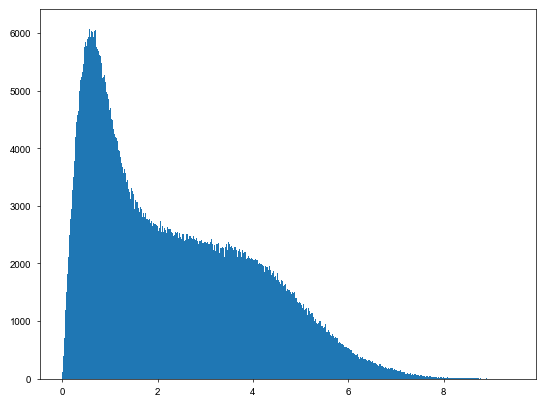

In [6]:
piv_vel = np.sqrt(piv_u**2 + piv_v**2)
piv_u_unit, piv_v_unit = piv_u/piv_vel, piv_v/piv_vel
_ = plt.hist(piv_vel.flatten(), bins=1024)
piv_vel_levels= np.linspace(0,8,128)

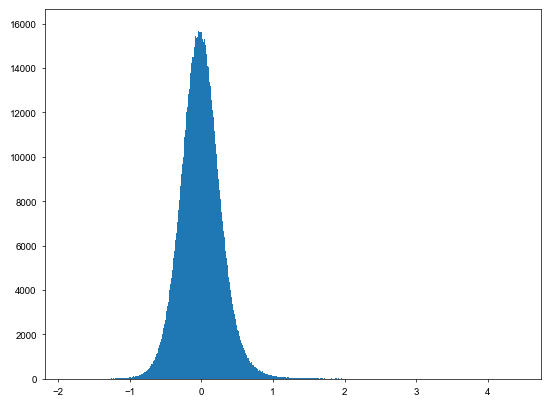

In [7]:
_ = plt.hist(div.flatten(), bins=1024)
div_levels= np.linspace(-1.5, 1.5, 128)

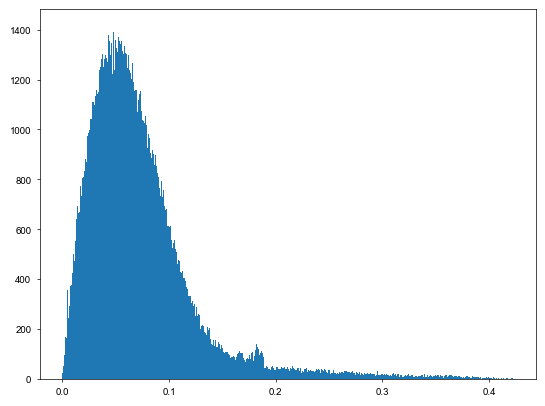

In [8]:
qanglex, qangley = nematic_to_vector(qxx, qxy)
qmag = np.sqrt(qxx**2 + qxy**2) 
qanglex_unit, qangley_unit = qanglex/qmag, qangley/qmag
_ = plt.hist(qmag.flatten(), bins=1024)
qmag_levels= np.linspace(0,0.4,128)

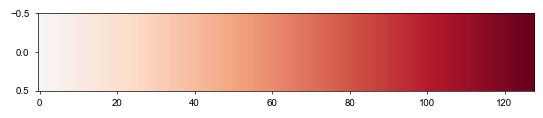

In [9]:
# new cmap
new_reds_cmap = mpl.colors.ListedColormap(mpl.colormaps['RdBu'](np.linspace(0.5,0,1024)))
plt.imshow([np.arange(128)], aspect=20, cmap=new_reds_cmap)
plt.show()

# new_blues_cmap = mpl.colormaps['RdGy'](np.linspace(0.5, 0, 1024))
# new_blues_cmap.T[[0,2]] = new_blues_cmap.T[[2, 0]]
# # new_blues_cmap.T[[1]] = new_blues_cmap.T[[2]]
# new_blues_cmap = mpl.colors.ListedColormap(new_blues_cmap)
# plt.imshow([np.arange(128)], aspect=20, cmap=new_blues_cmap)
# plt.show()

# cdict = {'red':   [[0.0,  0.0, 0.0],
#                    [0.25, 0, 0],
#                    [0.5,  1, 1],
#                    [0.75, 1, 1],
#                    [1.0,  0.5, 1.0]],
#          'green': [[0.0,  0.75*0.5, 0.75*0.5],
#                    [0.25, 0.75, 0.75],
#                    [0.5,  1, 1],
#                    [0.75, 0, 0],
#                    [1.0,  0.0, 0.0]],
#          'blue':  [[0.0,  0.75*0.5, 0.75*0.5],
#                    [0.25, 0.75, 0.75],
#                    [0.5,  1, 1],
#                    [0.75, 0, 0],
#                    [1.0,  0.0, 0.0]]}
# cnrd_cmap = mpl.colors.LinearSegmentedColormap('CnRd', segmentdata=cdict, N=1024)

# plt.imshow([np.arange(128)], aspect=20, cmap=cnrd_cmap)
# plt.show()

# rgba = cnrd_cmap(np.linspace(0,1,1024))
# fig, ax = plt.subplots(figsize=(4, 3), layout='constrained')
# col = ['r', 'g', 'b']
# for xx in [0.25, 0.5, 0.75]:
#     ax.axvline(xx, color='0.7', linestyle='--')
# for i in range(3):
#     ax.plot(np.arange(1024)/1024, rgba[:, i], color=col[i])
# ax.set_xlabel('index')
# ax.set_ylabel('RGB')
# plt.show()


##### middle, not moving region

In [10]:
roi1_x, roi1_y = 0, 570

frame 34


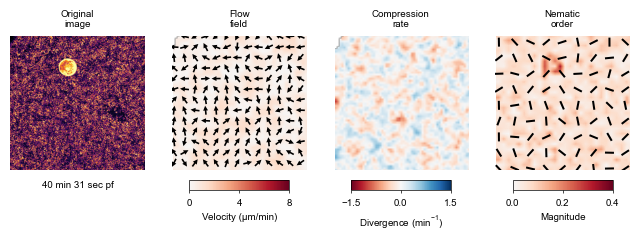

frame 67


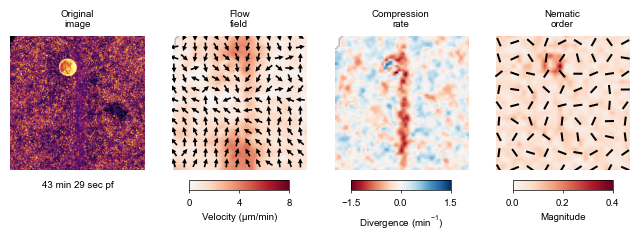

frame 84


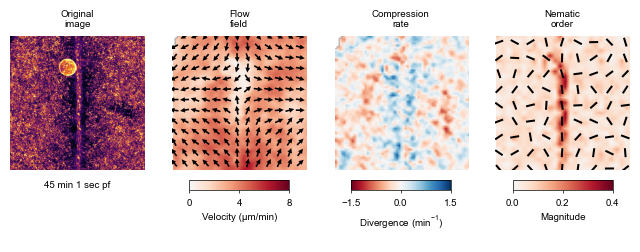

In [11]:
# Create a folder
folder_name = movie_name[:-4] + '_nematic-video-div_middle_qmag_svg'
create_folder(folder_name)

from mpl_toolkits.axes_grid1 import make_axes_locatable

for frame in [34,67,84]:
# for frame in [67]:
    print('frame ' + str(frame))

    fig, axs = plt.subplots(2,4,figsize=[8,3], gridspec_kw={"height_ratios": [1,0.03]})

    caxs = []
    for i in range(0,4):
        caxs.append(make_axes_locatable(axs[0,i]).append_axes('bottom', size=0.1, pad=0.1, box_aspect=1/10))

    # panel_1: raw image
    im0 = axs[0,0].imshow(movie[frame], cmap = 'inferno', vmin = video_vmin, vmax = video_vmax)
    caxs[0].set_axis_off()

    # panel_2: pivlab
    piv_x_step = (piv_x[1,0] - piv_x[0,0]) / 2
    piv_y_step = (piv_y[0,1] - piv_y[0,0]) / 2
    im1 = axs[0,1].imshow(piv_vel[frame].T, extent=[piv_x[0,0] - piv_x_step, piv_x[-1,0] + piv_x_step, piv_y[0,-1] - piv_y_step, piv_y[0,0] + piv_y_step],
                          cmap=new_reds_cmap, vmin=piv_vel_levels[0], vmax=piv_vel_levels[-1], interpolation='bilinear')
    
    axs[0,1].invert_yaxis()
    cb1 = fig.colorbar(im1, cax=caxs[1], orientation='horizontal', label='Velocity (\u03BCm/min)', ticks = [0, 4, 8])

    stride = 5
    piv_x_filtering = np.logical_and(piv_x[::stride, ::stride]>roi1_x, piv_x[::stride, ::stride]<roi1_x+1024)
    piv_y_filtering = np.logical_and(piv_y[::stride, ::stride]>roi1_y, piv_y[::stride, ::stride]<roi1_y+1024)
    piv_xy_filtering = np.logical_and(piv_x_filtering, piv_y_filtering)
    axs[0,1].quiver(piv_x[::stride, ::stride][piv_xy_filtering].flatten(),
                    piv_y[::stride, ::stride][piv_xy_filtering].flatten(),
                    piv_u_unit[frame][::stride, ::stride][piv_xy_filtering].flatten(),
                    -piv_v_unit[frame][::stride, ::stride][piv_xy_filtering].flatten(),
                    scale = 15,
                    width = 0.012, pivot = 'mid', headwidth =3, headlength = 3, headaxislength = 3,
                    color='black')
    
    # panel_3: divergence
    im2 = axs[0,2].imshow(div[frame].T, extent=[piv_x[0,0] - piv_x_step, piv_x[-1,0] + piv_x_step, piv_y[0,-1] - piv_y_step, piv_y[0,0] + piv_y_step],
                        cmap='RdBu', vmin=div_levels[0], vmax=div_levels[-1], interpolation='bilinear')
    axs[0,2].invert_yaxis()
    cb2 = fig.colorbar(im2, cax=caxs[2], orientation='horizontal', label='Divergence ($\\mathregular{min^{-1}}$)', ticks = [-1.5, 0, 1.5])

    # panel_4: nematic order
    qx_step = (qx[0,1] - qx[0,0])/2
    qy_step = (qy[1,0] - qy[0,0])/2
    im3 = axs[0,3].imshow(qmag[frame], extent=[qx[0,0]-qx_step, qx[0,-1]-qx_step, qy[-1,0]-qy_step, qy[0,0]-qy_step],
                         cmap=new_reds_cmap, vmin=qmag_levels[0], vmax=qmag_levels[-1], interpolation='bilinear')
    axs[0,3].invert_yaxis()
    cb3 = fig.colorbar(im3, cax=caxs[3], orientation='horizontal', label='Magnitude', ticks = [0, 0.2, 0.4])

    stride = 3
    stride_offset = 0
    q_x_filtering = np.logical_and(qx[stride_offset::stride, stride_offset::stride]>roi1_x, qx[stride_offset::stride, stride_offset::stride]<roi1_x+1024)
    q_y_filtering = np.logical_and(qy[stride_offset::stride, stride_offset::stride]>roi1_y, qy[stride_offset::stride, stride_offset::stride]<roi1_y+1024)
    q_xy_filtering = np.logical_and(q_x_filtering, q_y_filtering)
    axs[0,3].quiver(qx[stride_offset::stride, stride_offset::stride][q_xy_filtering],
                    qy[stride_offset::stride, stride_offset::stride][q_xy_filtering],
                    qanglex_unit[frame][stride_offset::stride, stride_offset::stride][q_xy_filtering],
                    qangley_unit[frame][stride_offset::stride, stride_offset::stride][q_xy_filtering],
                    color='black',
                    scale = 15, width = 0.015, pivot = 'mid', headwidth =0, headlength = 0, headaxislength = 0)

    # time
    caxs[0].text(0.5, 0.5, sec_to_min_and_sec(dev_time[frame]*60) +' pf', color='black', fontsize=7, va='center', ha='center')

    # titles
    axs[0,0].set_title('Original\nimage', fontsize=7)
    axs[0,1].set_title('Flow\nfield', fontsize=7)
    axs[0,2].set_title('Compression\nrate', fontsize=7)
    axs[0,3].set_title('Nematic\norder', fontsize=7)

    [axs[0, i].set_axis_off() for i in range(4)]
    [axs[1, i].set_axis_off() for i in range(4)]
    [axs[0, i].set_aspect('equal') for i in range(4)]

    # ranges
    [axs[0, i].set_xlim(roi1_x, roi1_x+1024) for i in range(4)]
    [axs[0, i].set_ylim(roi1_y+1024, roi1_y) for i in range(4)]

    fig.align_labels(axs=caxs)
    fig.align_titles()

    plt.savefig(folder_name + '/f' + str(frame) + '.svg')
    # plt.savefig(folder_name + '/f' + str(frame) + '.png', dpi=500, pad_inches = 0)
    plt.show()


frame 34


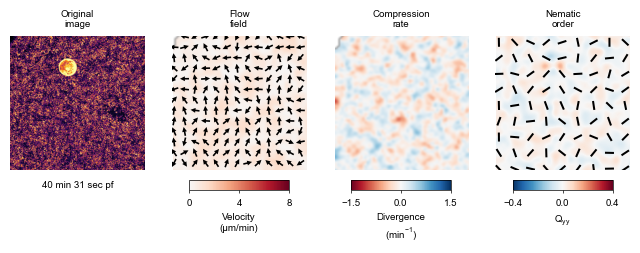

frame 67


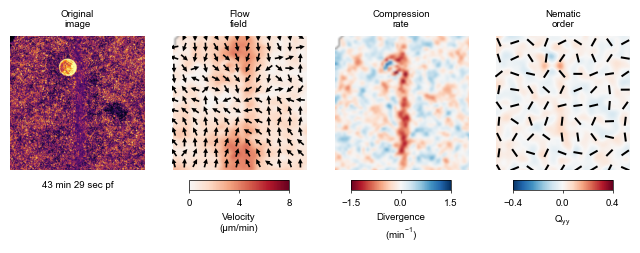

frame 84


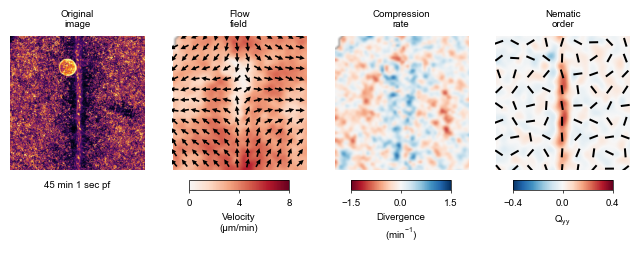

In [12]:
# Create a folder
folder_name = movie_name[:-4] + '_nematic-video-div_middle_qyy_svg'
create_folder(folder_name)

from mpl_toolkits.axes_grid1 import make_axes_locatable

for frame in [34,67,84]:
# for frame in [67]:
    print('frame ' + str(frame))

    fig, axs = plt.subplots(2,4,figsize=[8,3], gridspec_kw={"height_ratios": [1,0.03]})

    caxs = []
    for i in range(0,4):
        caxs.append(make_axes_locatable(axs[0,i]).append_axes('bottom', size=0.1, pad=0.1, box_aspect=1/10))

    # panel_1: raw image
    im0 = axs[0,0].imshow(movie[frame], cmap = 'inferno', vmin = video_vmin, vmax = video_vmax)
    caxs[0].set_axis_off()

    # panel_2: pivlab
    piv_x_step = (piv_x[1,0] - piv_x[0,0]) / 2
    piv_y_step = (piv_y[0,1] - piv_y[0,0]) / 2
    im1 = axs[0,1].imshow(piv_vel[frame].T, extent=[piv_x[0,0] - piv_x_step, piv_x[-1,0] + piv_x_step, piv_y[0,-1] - piv_y_step, piv_y[0,0] + piv_y_step],
                          cmap=new_reds_cmap, vmin=piv_vel_levels[0], vmax=piv_vel_levels[-1], interpolation='bicubic')
    
    axs[0,1].invert_yaxis()
    cb1 = fig.colorbar(im1, cax=caxs[1], orientation='horizontal', label='Velocity\n(\u03BCm/min)', ticks = [0, 4, 8])

    stride = 5
    piv_x_filtering = np.logical_and(piv_x[::stride, ::stride]>roi1_x, piv_x[::stride, ::stride]<roi1_x+1024)
    piv_y_filtering = np.logical_and(piv_y[::stride, ::stride]>roi1_y, piv_y[::stride, ::stride]<roi1_y+1024)
    piv_xy_filtering = np.logical_and(piv_x_filtering, piv_y_filtering)
    axs[0,1].quiver(piv_x[::stride, ::stride][piv_xy_filtering].flatten(),
                    piv_y[::stride, ::stride][piv_xy_filtering].flatten(),
                    piv_u_unit[frame][::stride, ::stride][piv_xy_filtering].flatten(),
                    -piv_v_unit[frame][::stride, ::stride][piv_xy_filtering].flatten(),
                    scale = 15,
                    width = 0.012, pivot = 'mid', headwidth =3, headlength = 3, headaxislength = 3,
                    color='black')
    
    # panel_2 (plan_b): pivlab
    # im1 = axs[0,1].imshow(np.ones_like(movie[frame]), cmap='Greys_r', vmin=0, vmax=10)
    # axs[0,1].invert_yaxis()
    # cb1 = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0, 360), cmap="hsv"),
    #                    cax=caxs[1], orientation='horizontal', label='Orientation (°)$\mathregular{^{ }}$', ticks = [0, 180, 360])

    # orientation_cmap = plt.colormaps["hsv"]
    # orientation_colors = np.arctan2(piv_v[frame], -piv_u[frame])/(2*np.pi)+0.5

    # stride = 5
    # piv_x_filtering = np.logical_and(piv_x[::stride, ::stride]>roi1_x, piv_x[::stride, ::stride]<roi1_x+1024)
    # piv_y_filtering = np.logical_and(piv_y[::stride, ::stride]>roi1_y, piv_y[::stride, ::stride]<roi1_y+1024)
    # piv_xy_filtering = np.logical_and(piv_x_filtering, piv_y_filtering)
    # axs[0,1].quiver(piv_x[::stride, ::stride][piv_xy_filtering],
    #                 piv_y[::stride, ::stride][piv_xy_filtering],
    #                 piv_u[frame][::stride, ::stride][piv_xy_filtering],
    #                 -piv_v[frame][::stride, ::stride][piv_xy_filtering],
    #                 scale = 25, width = 0.01, pivot = 'mid', headwidth =3, headlength = 5, headaxislength = 5,
    #                 color = orientation_cmap(orientation_colors[::stride, ::stride][piv_xy_filtering]))



    # panel_3: divergence
    im2 = axs[0,2].imshow(div[frame].T, extent=[piv_x[0,0] - piv_x_step, piv_x[-1,0] + piv_x_step, piv_y[0,-1] - piv_y_step, piv_y[0,0] + piv_y_step],
                        cmap='RdBu', vmin=div_levels[0], vmax=div_levels[-1], interpolation='bicubic')
    axs[0,2].invert_yaxis()
    cb2 = fig.colorbar(im2, cax=caxs[2], orientation='horizontal', label='Divergence\n($\\mathregular{min^{-1}}$)', ticks = [-1.5, 0, 1.5])

    # panel_4: nematic order
    qx_step = (qx[0,1] - qx[0,0])/2
    qy_step = (qy[1,0] - qy[0,0])/2
    im3 = axs[0,3].imshow(-qxx[frame], extent=[qx[0,0]-qx_step, qx[0,-1]-qx_step, qy[-1,0]-qy_step, qy[0,0]-qy_step],
                         cmap='RdBu_r', vmin=-qmag_levels[-1], vmax=qmag_levels[-1], interpolation='bicubic')
    axs[0,3].invert_yaxis()
    cb3 = fig.colorbar(im3, cax=caxs[3], orientation='horizontal', label='$\\mathregular{Q_{yy}}$', ticks = [-0.4, 0.0, 0.4])

    stride = 3
    stride_offset = 0
    q_x_filtering = np.logical_and(qx[stride_offset::stride, stride_offset::stride]>roi1_x, qx[stride_offset::stride, stride_offset::stride]<roi1_x+1024)
    q_y_filtering = np.logical_and(qy[stride_offset::stride, stride_offset::stride]>roi1_y, qy[stride_offset::stride, stride_offset::stride]<roi1_y+1024)
    q_xy_filtering = np.logical_and(q_x_filtering, q_y_filtering)
    axs[0,3].quiver(qx[stride_offset::stride, stride_offset::stride][q_xy_filtering],
                    qy[stride_offset::stride, stride_offset::stride][q_xy_filtering],
                    qanglex_unit[frame][stride_offset::stride, stride_offset::stride][q_xy_filtering],
                    qangley_unit[frame][stride_offset::stride, stride_offset::stride][q_xy_filtering],
                    color='black',
                    scale = 15, width = 0.015, pivot = 'mid', headwidth =0, headlength = 0, headaxislength = 0)

    # time
    caxs[0].text(0.5, 0.5, sec_to_min_and_sec(dev_time[frame]*60) +' pf', color='black', fontsize=7, va='center', ha='center')

    # titles
    axs[0,0].set_title('Original\nimage', fontsize=7)
    axs[0,1].set_title('Flow\nfield', fontsize=7)
    axs[0,2].set_title('Compression\nrate', fontsize=7)
    axs[0,3].set_title('Nematic\norder', fontsize=7)

    [axs[0, i].set_axis_off() for i in range(4)]
    [axs[1, i].set_axis_off() for i in range(4)]
    [axs[0, i].set_aspect('equal') for i in range(4)]

    # ranges
    [axs[0, i].set_xlim(roi1_x, roi1_x+1024) for i in range(4)]
    [axs[0, i].set_ylim(roi1_y+1024, roi1_y) for i in range(4)]

    fig.align_labels(axs=caxs)
    fig.align_titles()

    plt.savefig(folder_name + '/f' + str(frame) + '.svg')
    # plt.savefig(folder_name + '/f' + str(frame) + '.png', dpi=500, pad_inches = 0)
    plt.show()


In [13]:
# how the window moves
a = np.array([[64-1, 1], [84-1, 1]])
b = np.array([50*16, 85*16])
c = np.linalg.solve(a,b)
roi2_ys = np.array([int(np.dot([frame, 1], c)) for frame in range(frames-1)])
roi2_ys[roi2_ys <= roi1_y] = roi1_y

frame 84


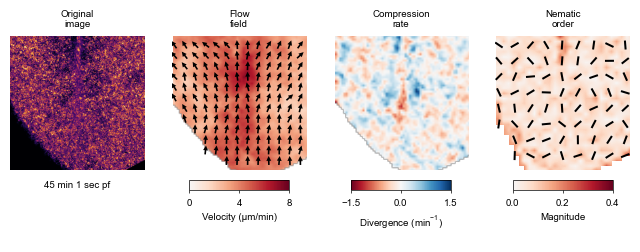

In [14]:
# Create a folder
folder_name = movie_name[:-4] + '_nematic-video-div_edge_qmag_svg'
create_folder(folder_name)

from mpl_toolkits.axes_grid1 import make_axes_locatable

for frame in [84]:
    print('frame ' + str(frame))

    fig, axs = plt.subplots(2,4,figsize=[8,3], gridspec_kw={"height_ratios": [1,0.03]})

    caxs = []
    for i in range(0,4):
        caxs.append(make_axes_locatable(axs[0,i]).append_axes('bottom', size=0.1, pad=0.1, box_aspect=1/10))

    # panel_1: raw image
    im0 = axs[0,0].imshow(movie[frame], cmap = 'inferno', vmin = video_vmin, vmax = video_vmax)
    caxs[0].set_axis_off()

    # panel_2: pivlab
    piv_x_step = (piv_x[1,0] - piv_x[0,0]) / 2
    piv_y_step = (piv_y[0,1] - piv_y[0,0]) / 2
    im1 = axs[0,1].imshow(piv_vel[frame].T, extent=[piv_x[0,0] - piv_x_step, piv_x[-1,0] + piv_x_step, piv_y[0,-1] - piv_y_step, piv_y[0,0] + piv_y_step],
                          cmap=new_reds_cmap, vmin=piv_vel_levels[0], vmax=piv_vel_levels[-1], interpolation='bilinear')
    
    axs[0,1].invert_yaxis()
    cb1 = fig.colorbar(im1, cax=caxs[1], orientation='horizontal', label='Velocity (\u03BCm/min)', ticks = [0, 4, 8])

    stride = 5
    piv_x_filtering = np.logical_and(piv_x[::stride, ::stride]>roi1_x, piv_x[::stride, ::stride]<roi1_x+1024)
    piv_y_filtering = np.logical_and(piv_y[::stride, ::stride]>roi2_ys[frame], piv_y[::stride, ::stride]<roi2_ys[frame]+1024)
    piv_xy_filtering = np.logical_and(piv_x_filtering, piv_y_filtering)
    axs[0,1].quiver(piv_x[::stride, ::stride][piv_xy_filtering].flatten(),
                    piv_y[::stride, ::stride][piv_xy_filtering].flatten(),
                    piv_u_unit[frame][::stride, ::stride][piv_xy_filtering].flatten(),
                    -piv_v_unit[frame][::stride, ::stride][piv_xy_filtering].flatten(),
                    scale = 15,
                    width = 0.012, pivot = 'mid', headwidth =3, headlength = 3, headaxislength = 3,
                    color='black')
    
    # panel_2 (plan_b): pivlab
    # im1 = axs[0,1].imshow(np.ones_like(movie[frame]), cmap='Greys_r', vmin=0, vmax=10)
    # axs[0,1].invert_yaxis()
    # cb1 = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0, 360), cmap="hsv"),
    #                    cax=caxs[1], orientation='horizontal', label='Orientation (°)$\mathregular{^{ }}$', ticks = [0, 180, 360])

    # orientation_cmap = plt.colormaps["hsv"]
    # orientation_colors = np.arctan2(piv_v[frame], -piv_u[frame])/(2*np.pi)+0.5

    # stride = 5
    # piv_x_filtering = np.logical_and(piv_x[::stride, ::stride]>roi1_x, piv_x[::stride, ::stride]<roi1_x+1024)
    # piv_y_filtering = np.logical_and(piv_y[::stride, ::stride]>roi1_y, piv_y[::stride, ::stride]<roi1_y+1024)
    # piv_xy_filtering = np.logical_and(piv_x_filtering, piv_y_filtering)
    # axs[0,1].quiver(piv_x[::stride, ::stride][piv_xy_filtering],
    #                 piv_y[::stride, ::stride][piv_xy_filtering],
    #                 piv_u[frame][::stride, ::stride][piv_xy_filtering],
    #                 -piv_v[frame][::stride, ::stride][piv_xy_filtering],
    #                 scale = 25, width = 0.01, pivot = 'mid', headwidth =3, headlength = 5, headaxislength = 5,
    #                 color = orientation_cmap(orientation_colors[::stride, ::stride][piv_xy_filtering]))



    # panel_3: divergence
    im2 = axs[0,2].imshow(div[frame].T, extent=[piv_x[0,0] - piv_x_step, piv_x[-1,0] + piv_x_step, piv_y[0,-1] - piv_y_step, piv_y[0,0] + piv_y_step],
                        cmap='RdBu', vmin=div_levels[0], vmax=div_levels[-1], interpolation='bilinear')
    axs[0,2].invert_yaxis()
    cb2 = fig.colorbar(im2, cax=caxs[2], orientation='horizontal', label='Divergence ($\\mathregular{min^{-1}}$)', ticks = [-1.5, 0, 1.5])

    # panel_4: nematic order
    qx_step = (qx[0,1] - qx[0,0])/2
    qy_step = (qy[1,0] - qy[0,0])/2
    im3 = axs[0,3].imshow(qmag[frame], extent=[qx[0,0]-qx_step, qx[0,-1]-qx_step, qy[-1,0]-qy_step, qy[0,0]-qy_step],
                         cmap=new_reds_cmap, vmin=qmag_levels[0], vmax=qmag_levels[-1], interpolation='bilinear')
    axs[0,3].invert_yaxis()
    cb3 = fig.colorbar(im3, cax=caxs[3], orientation='horizontal', label='Magnitude', ticks = [0, 0.2, 0.4])

    stride = 3
    stride_offset = 0
    q_x_filtering = np.logical_and(qx[stride_offset::stride, stride_offset::stride]>roi1_x, qx[stride_offset::stride, stride_offset::stride]<roi1_x+1024)
    q_y_filtering = np.logical_and(qy[stride_offset::stride, stride_offset::stride]>roi2_ys[frame], qy[stride_offset::stride, stride_offset::stride]<roi2_ys[frame]+1024)
    q_xy_filtering = np.logical_and(q_x_filtering, q_y_filtering)
    axs[0,3].quiver(qx[stride_offset::stride, stride_offset::stride][q_xy_filtering],
                    qy[stride_offset::stride, stride_offset::stride][q_xy_filtering],
                    qanglex_unit[frame][stride_offset::stride, stride_offset::stride][q_xy_filtering],
                    qangley_unit[frame][stride_offset::stride, stride_offset::stride][q_xy_filtering],
                    color='black',
                    scale = 15, width = 0.015, pivot = 'mid', headwidth =0, headlength = 0, headaxislength = 0)

    # time
    caxs[0].text(0.5, 0.5, sec_to_min_and_sec(dev_time[frame]*60) +' pf', color='black', fontsize=7, va='center', ha='center')

    # titles
    axs[0,0].set_title('Original\nimage', fontsize=7)
    axs[0,1].set_title('Flow\nfield', fontsize=7)
    axs[0,2].set_title('Compression\nrate', fontsize=7)
    axs[0,3].set_title('Nematic\norder', fontsize=7)

    [axs[0, i].set_axis_off() for i in range(4)]
    [axs[1, i].set_axis_off() for i in range(4)]
    [axs[0, i].set_aspect('equal') for i in range(4)]

    # ranges
    [axs[0, i].set_xlim(roi1_x, roi1_x+1024) for i in range(4)]
    [axs[0, i].set_ylim(roi2_ys[frame]+1024, roi2_ys[frame]) for i in range(4)]

    fig.align_labels(axs=caxs)
    fig.align_titles()

    # plt.savefig(folder_name + '/f' + str(frame) + '.png', dpi=400,pad_inches = 0)
    plt.savefig(folder_name + '/f' + str(frame) + '.svg')
    plt.show()


frame 84


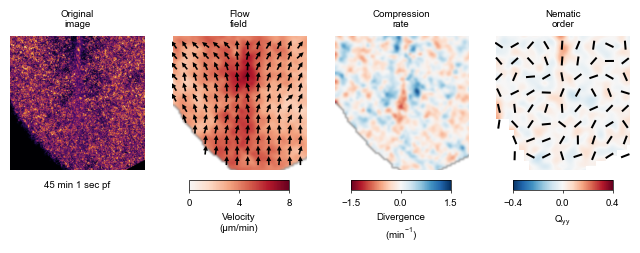

In [15]:
# Create a folder
folder_name = movie_name[:-4] + '_nematic-video-div_edge_qyy_svg'
create_folder(folder_name)

from mpl_toolkits.axes_grid1 import make_axes_locatable

for frame in [84]:
    print('frame ' + str(frame))

    fig, axs = plt.subplots(2,4,figsize=[8,3], gridspec_kw={"height_ratios": [1,0.03]})

    caxs = []
    for i in range(0,4):
        caxs.append(make_axes_locatable(axs[0,i]).append_axes('bottom', size=0.1, pad=0.1, box_aspect=1/10))

    # panel_1: raw image
    im0 = axs[0,0].imshow(movie[frame], cmap = 'inferno', vmin = video_vmin, vmax = video_vmax)
    caxs[0].set_axis_off()

    # panel_2: pivlab
    piv_x_step = (piv_x[1,0] - piv_x[0,0]) / 2
    piv_y_step = (piv_y[0,1] - piv_y[0,0]) / 2
    im1 = axs[0,1].imshow(piv_vel[frame].T, extent=[piv_x[0,0] - piv_x_step, piv_x[-1,0] + piv_x_step, piv_y[0,-1] - piv_y_step, piv_y[0,0] + piv_y_step],
                          cmap=new_reds_cmap, vmin=piv_vel_levels[0], vmax=piv_vel_levels[-1], interpolation='bicubic')
    
    axs[0,1].invert_yaxis()
    cb1 = fig.colorbar(im1, cax=caxs[1], orientation='horizontal', label='Velocity\n(\u03BCm/min)', ticks = [0, 4, 8])

    stride = 5
    piv_x_filtering = np.logical_and(piv_x[::stride, ::stride]>roi1_x, piv_x[::stride, ::stride]<roi1_x+1024)
    piv_y_filtering = np.logical_and(piv_y[::stride, ::stride]>roi2_ys[frame], piv_y[::stride, ::stride]<roi2_ys[frame]+1024)
    piv_xy_filtering = np.logical_and(piv_x_filtering, piv_y_filtering)
    axs[0,1].quiver(piv_x[::stride, ::stride][piv_xy_filtering].flatten(),
                    piv_y[::stride, ::stride][piv_xy_filtering].flatten(),
                    piv_u_unit[frame][::stride, ::stride][piv_xy_filtering].flatten(),
                    -piv_v_unit[frame][::stride, ::stride][piv_xy_filtering].flatten(),
                    scale = 15,
                    width = 0.012, pivot = 'mid', headwidth =3, headlength = 3, headaxislength = 3,
                    color='black')
    
    # panel_2 (plan_b): pivlab
    # im1 = axs[0,1].imshow(np.ones_like(movie[frame]), cmap='Greys_r', vmin=0, vmax=10)
    # axs[0,1].invert_yaxis()
    # cb1 = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0, 360), cmap="hsv"),
    #                    cax=caxs[1], orientation='horizontal', label='Orientation (°)$\mathregular{^{ }}$', ticks = [0, 180, 360])

    # orientation_cmap = plt.colormaps["hsv"]
    # orientation_colors = np.arctan2(piv_v[frame], -piv_u[frame])/(2*np.pi)+0.5

    # stride = 5
    # piv_x_filtering = np.logical_and(piv_x[::stride, ::stride]>roi1_x, piv_x[::stride, ::stride]<roi1_x+1024)
    # piv_y_filtering = np.logical_and(piv_y[::stride, ::stride]>roi1_y, piv_y[::stride, ::stride]<roi1_y+1024)
    # piv_xy_filtering = np.logical_and(piv_x_filtering, piv_y_filtering)
    # axs[0,1].quiver(piv_x[::stride, ::stride][piv_xy_filtering],
    #                 piv_y[::stride, ::stride][piv_xy_filtering],
    #                 piv_u[frame][::stride, ::stride][piv_xy_filtering],
    #                 -piv_v[frame][::stride, ::stride][piv_xy_filtering],
    #                 scale = 25, width = 0.01, pivot = 'mid', headwidth =3, headlength = 5, headaxislength = 5,
    #                 color = orientation_cmap(orientation_colors[::stride, ::stride][piv_xy_filtering]))



    # panel_3: divergence
    im2 = axs[0,2].imshow(div[frame].T, extent=[piv_x[0,0] - piv_x_step, piv_x[-1,0] + piv_x_step, piv_y[0,-1] - piv_y_step, piv_y[0,0] + piv_y_step],
                        cmap='RdBu', vmin=div_levels[0], vmax=div_levels[-1], interpolation='bicubic')
    axs[0,2].invert_yaxis()
    cb2 = fig.colorbar(im2, cax=caxs[2], orientation='horizontal', label='Divergence\n($\\mathregular{min^{-1}}$)', ticks = [-1.5, 0, 1.5])

    # panel_4: nematic order
    qx_step = (qx[0,1] - qx[0,0])/2
    qy_step = (qy[1,0] - qy[0,0])/2
    im3 = axs[0,3].imshow(-qxx[frame], extent=[qx[0,0]-qx_step, qx[0,-1]-qx_step, qy[-1,0]-qy_step, qy[0,0]-qy_step],
                         cmap='RdBu_r', vmin=-qmag_levels[-1], vmax=qmag_levels[-1], interpolation='bicubic')
    axs[0,3].invert_yaxis()
    cb3 = fig.colorbar(im3, cax=caxs[3], orientation='horizontal', label='$\\mathregular{Q_{yy}}$', ticks = [-0.4, 0.0, 0.4])

    stride = 3
    stride_offset = 0
    q_x_filtering = np.logical_and(qx[stride_offset::stride, stride_offset::stride]>roi1_x, qx[stride_offset::stride, stride_offset::stride]<roi1_x+1024)
    q_y_filtering = np.logical_and(qy[stride_offset::stride, stride_offset::stride]>roi2_ys[frame], qy[stride_offset::stride, stride_offset::stride]<roi2_ys[frame]+1024)
    q_xy_filtering = np.logical_and(q_x_filtering, q_y_filtering)
    axs[0,3].quiver(qx[stride_offset::stride, stride_offset::stride][q_xy_filtering],
                    qy[stride_offset::stride, stride_offset::stride][q_xy_filtering],
                    qanglex_unit[frame][stride_offset::stride, stride_offset::stride][q_xy_filtering],
                    qangley_unit[frame][stride_offset::stride, stride_offset::stride][q_xy_filtering],
                    color='black',
                    scale = 15, width = 0.015, pivot = 'mid', headwidth =0, headlength = 0, headaxislength = 0)

    # time
    caxs[0].text(0.5, 0.5, sec_to_min_and_sec(dev_time[frame]*60) +' pf', color='black', fontsize=7, va='center', ha='center')

    # titles
    axs[0,0].set_title('Original\nimage', fontsize=7)
    axs[0,1].set_title('Flow\nfield', fontsize=7)
    axs[0,2].set_title('Compression\nrate', fontsize=7)
    axs[0,3].set_title('Nematic\norder', fontsize=7)

    [axs[0, i].set_axis_off() for i in range(4)]
    [axs[1, i].set_axis_off() for i in range(4)]
    [axs[0, i].set_aspect('equal') for i in range(4)]

    # ranges
    [axs[0, i].set_xlim(roi1_x, roi1_x+1024) for i in range(4)]
    [axs[0, i].set_ylim(roi2_ys[frame]+1024, roi2_ys[frame]) for i in range(4)]

    fig.align_labels(axs=caxs)
    fig.align_titles()

    # plt.savefig(folder_name + '/f' + str(frame) + '.png', dpi=400,pad_inches = 0)
    plt.savefig(folder_name + '/f' + str(frame) + '.svg')
    plt.show()


Make the movies

In [12]:
(dev_time[1]-dev_time[0])*60

np.float64(5.400000000000205)

In [11]:
dev_time[172-116-10]*60

np.float64(2496.0)

In [ ]:
# adjust the vmin and vmax
a = movie[172-116-10:frames, roi1_y+1024, roi1_x:roi1_x+1024]
print(np.percentile(a, (0.5,99)))


[ 267. 1642.]


frame 46


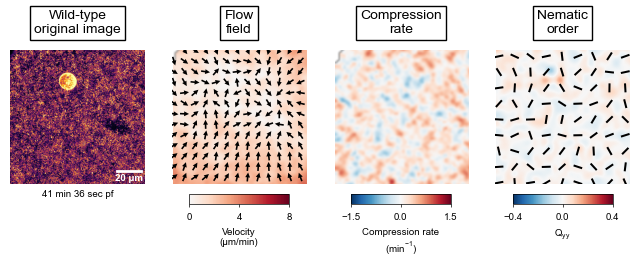

frame 47


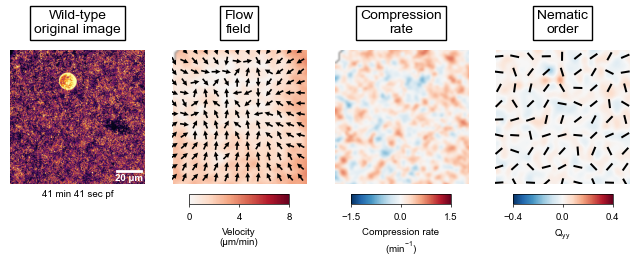

frame 48


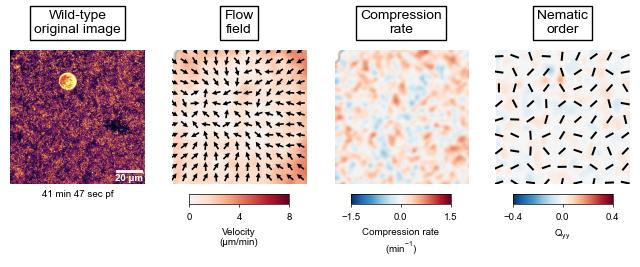

frame 49


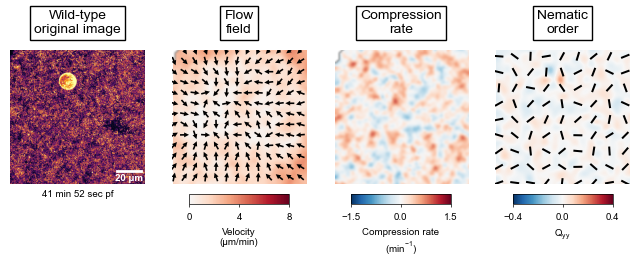

frame 50


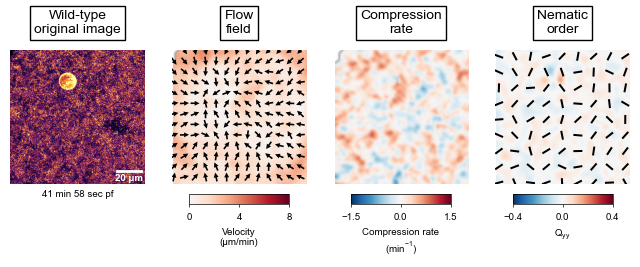

frame 51
frame 52
frame 53
frame 54
frame 55
frame 56
frame 57
frame 58
frame 59
frame 60
frame 61
frame 62
frame 63
frame 64
frame 65
frame 66
frame 67
frame 68
frame 69
frame 70
frame 71
frame 72
frame 73
frame 74
frame 75
frame 76
frame 77
frame 78
frame 79
frame 80
frame 81
frame 82
frame 83
frame 84
frame 85
frame 86
frame 87
frame 88
frame 89
frame 90
frame 91
frame 92
frame 93
frame 94
frame 95
frame 96
frame 97
frame 98
frame 99
frame 100
frame 101
frame 102
frame 103
frame 104
frame 105
frame 106
frame 107
frame 108
frame 109
frame 110
frame 111
frame 112
frame 113
frame 114
frame 115
frame 116
frame 117
frame 118
frame 119
frame 120
frame 121
frame 122
frame 123
frame 124
frame 125
frame 126
frame 127
frame 128
frame 129
frame 130
frame 131
frame 132
frame 133
frame 134
frame 135
frame 136
frame 137
frame 138


In [ ]:
# Create a folder
folder_name = movie_name[:-4] + '_nematic-video-div_middle_qyy_png'
create_folder(folder_name)

from mpl_toolkits.axes_grid1 import make_axes_locatable
j = 0
# for frame in [34,67,84]:
# for frame in [80]:

for frame in range(172-116-10, frames-1):
    j += 1
    print('frame ' + str(frame))

    fig, axs = plt.subplots(2,4,figsize=[8, 3], gridspec_kw={"height_ratios": [1,0.03]})

    caxs = []
    for i in range(0,4):
        caxs.append(make_axes_locatable(axs[0,i]).append_axes('bottom', size=0.1, pad=0.1, box_aspect=1/10))

    # panel_1: raw image
    im0 = axs[0,0].imshow(movie[frame], cmap = 'inferno', vmin = video_vmin, vmax = video_vmax)
    caxs[0].set_axis_off()

    # panel_2: pivlab
    piv_x_step = (piv_x[1,0] - piv_x[0,0]) / 2
    piv_y_step = (piv_y[0,1] - piv_y[0,0]) / 2
    im1 = axs[0,1].imshow(piv_vel[frame].T, extent=[piv_x[0,0] - piv_x_step, piv_x[-1,0] + piv_x_step, piv_y[0,-1] - piv_y_step, piv_y[0,0] + piv_y_step],
                          cmap=new_reds_cmap, vmin=piv_vel_levels[0], vmax=piv_vel_levels[-1], interpolation='bicubic')
    
    axs[0,1].invert_yaxis()
    cb1 = fig.colorbar(im1, cax=caxs[1], orientation='horizontal', label='Velocity\n(\u03BCm/min)', ticks = [0, 4, 8])

    stride = 5
    piv_x_filtering = np.logical_and(piv_x[::stride, ::stride]>roi1_x, piv_x[::stride, ::stride]<roi1_x+1024)
    piv_y_filtering = np.logical_and(piv_y[::stride, ::stride]>roi1_y, piv_y[::stride, ::stride]<roi1_y+1024)
    piv_xy_filtering = np.logical_and(piv_x_filtering, piv_y_filtering)
    axs[0,1].quiver(piv_x[::stride, ::stride][piv_xy_filtering].flatten(),
                    piv_y[::stride, ::stride][piv_xy_filtering].flatten(),
                    piv_u_unit[frame][::stride, ::stride][piv_xy_filtering].flatten(),
                    -piv_v_unit[frame][::stride, ::stride][piv_xy_filtering].flatten(),
                    scale = 15,
                    width = 0.012, pivot = 'mid', headwidth =3, headlength = 3, headaxislength = 3,
                    color='black')
    
    # panel_2 (plan_b): pivlab
    # im1 = axs[0,1].imshow(np.ones_like(movie[frame]), cmap='Greys_r', vmin=0, vmax=10)
    # axs[0,1].invert_yaxis()
    # cb1 = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0, 360), cmap="hsv"),
    #                    cax=caxs[1], orientation='horizontal', label='Orientation (°)$\mathregular{^{ }}$', ticks = [0, 180, 360])

    # orientation_cmap = plt.colormaps["hsv"]
    # orientation_colors = np.arctan2(piv_v[frame], -piv_u[frame])/(2*np.pi)+0.5

    # stride = 5
    # piv_x_filtering = np.logical_and(piv_x[::stride, ::stride]>roi1_x, piv_x[::stride, ::stride]<roi1_x+1024)
    # piv_y_filtering = np.logical_and(piv_y[::stride, ::stride]>roi1_y, piv_y[::stride, ::stride]<roi1_y+1024)
    # piv_xy_filtering = np.logical_and(piv_x_filtering, piv_y_filtering)
    # axs[0,1].quiver(piv_x[::stride, ::stride][piv_xy_filtering],
    #                 piv_y[::stride, ::stride][piv_xy_filtering],
    #                 piv_u[frame][::stride, ::stride][piv_xy_filtering],
    #                 -piv_v[frame][::stride, ::stride][piv_xy_filtering],
    #                 scale = 25, width = 0.01, pivot = 'mid', headwidth =3, headlength = 5, headaxislength = 5,
    #                 color = orientation_cmap(orientation_colors[::stride, ::stride][piv_xy_filtering]))



    # panel_3: divergence
    im2 = axs[0,2].imshow(-div[frame].T, extent=[piv_x[0,0] - piv_x_step, piv_x[-1,0] + piv_x_step, piv_y[0,-1] - piv_y_step, piv_y[0,0] + piv_y_step],
                        cmap='RdBu_r', vmin=div_levels[0], vmax=div_levels[-1], interpolation='bicubic')
    axs[0,2].invert_yaxis()
    cb2 = fig.colorbar(im2, cax=caxs[2], orientation='horizontal', label='Compression rate\n($\\mathregular{min^{-1}}$)', ticks = [-1.5, 0, 1.5])

    # panel_4: nematic order
    qx_step = (qx[0,1] - qx[0,0])/2
    qy_step = (qy[1,0] - qy[0,0])/2
    im3 = axs[0,3].imshow(-qxx[frame], extent=[qx[0,0]-qx_step, qx[0,-1]-qx_step, qy[-1,0]-qy_step, qy[0,0]-qy_step],
                         cmap='RdBu_r', vmin=-qmag_levels[-1], vmax=qmag_levels[-1], interpolation='bicubic')
    axs[0,3].invert_yaxis()
    cb3 = fig.colorbar(im3, cax=caxs[3], orientation='horizontal', label='$\\mathregular{Q_{yy}}$', ticks = [-0.4, 0.0, 0.4])

    stride = 3
    stride_offset = 0
    q_x_filtering = np.logical_and(qx[stride_offset::stride, stride_offset::stride]>roi1_x, qx[stride_offset::stride, stride_offset::stride]<roi1_x+1024)
    q_y_filtering = np.logical_and(qy[stride_offset::stride, stride_offset::stride]>roi1_y, qy[stride_offset::stride, stride_offset::stride]<roi1_y+1024)
    q_xy_filtering = np.logical_and(q_x_filtering, q_y_filtering)
    axs[0,3].quiver(qx[stride_offset::stride, stride_offset::stride][q_xy_filtering],
                    qy[stride_offset::stride, stride_offset::stride][q_xy_filtering],
                    qanglex_unit[frame][stride_offset::stride, stride_offset::stride][q_xy_filtering],
                    qangley_unit[frame][stride_offset::stride, stride_offset::stride][q_xy_filtering],
                    color='black',
                    scale = 15, width = 0.015, pivot = 'mid', headwidth =0, headlength = 0, headaxislength = 0)


    # titles
    axs[0,0].set_title('Wild-type\noriginal image', fontsize=10, pad=12, bbox=dict(facecolor='none', edgecolor='black', boxstyle='square,pad=0.3'))
    axs[0,1].set_title('Flow\nfield', fontsize=10, pad=12, bbox=dict(facecolor='none', edgecolor='black', boxstyle='square,pad=0.3'))
    axs[0,2].set_title('Compression\nrate', fontsize=10, pad=12, bbox=dict(facecolor='none', edgecolor='black', boxstyle='square,pad=0.3'))
    axs[0,3].set_title('Nematic\norder', fontsize=10, pad=12, bbox=dict(facecolor='none', edgecolor='black', boxstyle='square,pad=0.3'))

    [axs[0, i].set_axis_off() for i in range(4)]
    [axs[1, i].set_axis_off() for i in range(4)]
    [axs[0, i].set_aspect('equal') for i in range(4)]

    # ranges
    [axs[0, i].set_xlim(roi1_x, roi1_x+1024) for i in range(4)]
    [axs[0, i].set_ylim(roi1_y+1024, roi1_y) for i in range(4)]

    # scale bar
    axs[0,0].plot([roi1_x+1024 - 20 / pixel_size - 25, roi1_x+1024 - 25], [roi1_y+1024-100]*2, color='white', lw=2)
    axs[0,0].text(x = roi1_x+1024 - 20 / pixel_size - 40, y = roi1_y+1024 - 25, s='20 \u03BCm', fontweight='bold', color='white', fontsize=7)

    fig.align_labels(axs=caxs)
    fig.align_titles()

    # time
    caxs[0].text(0.5, 1, sec_to_min_and_sec(dev_time[frame]*60) +' pf', color='black', fontsize=7, va='center', ha='center')

    # add annotations
    if frame >= 172-116 and frame <= 75:
        caxs[0].text(0.5, -0.5, 'Actin cable\nforming', color='tab:red', fontsize=10, fontweight='bold', va='top', ha='center', bbox=dict(facecolor='none', edgecolor='tab:red', boxstyle='square,pad=0.3'))
    elif frame > 75:
        caxs[0].text(0.5, -0.5, 'Actin cable\nestablished\nand extending', color='grey', fontsize=10, fontweight='bold', va='top', ha='center', bbox=dict(facecolor='none', edgecolor='grey', boxstyle='square,pad=0.3'))

    plt.savefig(folder_name + '/f' + str(frame) + '.png', dpi=500, bbox_inches = 'tight', pad_inches = 0.1)
    if j<=5:
        plt.show()
    else:
        plt.close()


In [136]:
172-116

56

kymo

In [12]:
movie_kymo = movie[:-1, (roi1_y+512-20):(roi1_y+512+20), roi1_x:(roi1_x+1024)]
movie_kymo = np.average(movie_kymo, axis=1)

piv_kymo_x_range = np.where(piv_x < 1024)[0]
piv_kymo_x_range = np.unique(piv_kymo_x_range)
piv_kymo_y_range = np.where(np.logical_and(piv_y>roi1_y+512-50, piv_y<roi1_y+512+50))[1]
piv_kymo_y_range = np.unique(piv_kymo_y_range)
piv_kymo_coord = np.meshgrid(piv_kymo_x_range, dev_time)
piv_kymo = piv_u[:, piv_kymo_x_range][:,:,piv_kymo_y_range]
piv_kymo = np.average(piv_kymo, axis=2)
div_kymo = div[:, piv_kymo_x_range][:,:,piv_kymo_y_range]
div_kymo = np.average(div_kymo, axis=2)

q_kymo_x_range = np.where(qx < 1024)[1]
q_kymo_x_range = np.unique(q_kymo_x_range)
q_kymo_y_range = np.where(np.logical_and(qy>roi1_y+512-50, qy<roi1_y+512+50))[0]
q_kymo_y_range = np.unique(q_kymo_y_range)
q_kymo_coord = np.meshgrid(q_kymo_x_range, dev_time)
q_kymo = -qxx[:-1, q_kymo_y_range][:,:,q_kymo_x_range]
q_kymo = np.average(q_kymo, axis=1)

kymo_start_time = dev_time[0] - (dev_time[1] - dev_time[0])
kymo_end_time = dev_time[-1] + (dev_time[1] - dev_time[0])

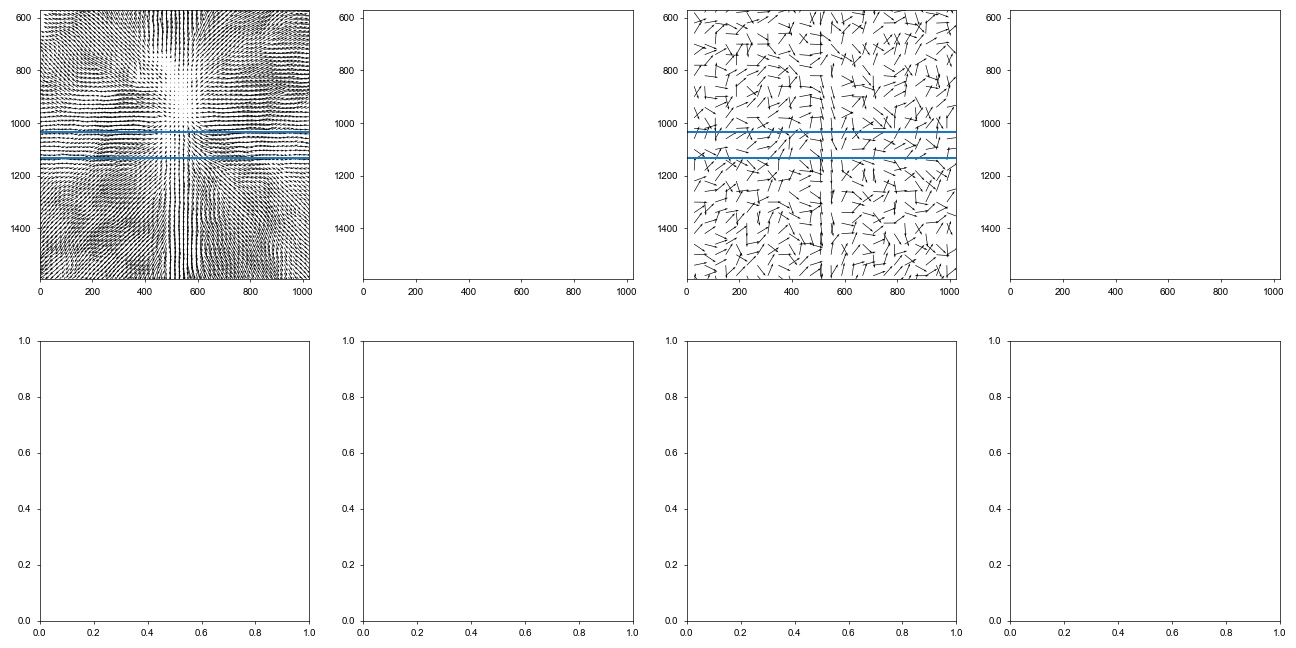

In [13]:
frame = 84
fig, axs = plt.subplots(2,4, figsize=[16,8])
axs[0, 0].quiver(piv_x, piv_y, piv_u[frame], piv_v[frame], scale=100)
axs[0, 0].axhline(y=roi1_y+512-50)
axs[0, 0].axhline(y=roi1_y+512+50)

axs[0, 2].quiver(qx, qy, qanglex_unit[frame], qangley_unit[frame], scale=20)
axs[0, 2].axhline(y=roi1_y+512-50)
axs[0, 2].axhline(y=roi1_y+512+50)

[axs[0, i].set_xlim(roi1_x, roi1_x+1024) for i in range(4)]
[axs[0, i].set_ylim(roi1_y+1024, roi1_y) for i in range(4)]
[axs[0, i].set_aspect('equal') for i in range(4)]
plt.show()

In [16]:
piv_vel_levels[-1]

np.float64(8.0)

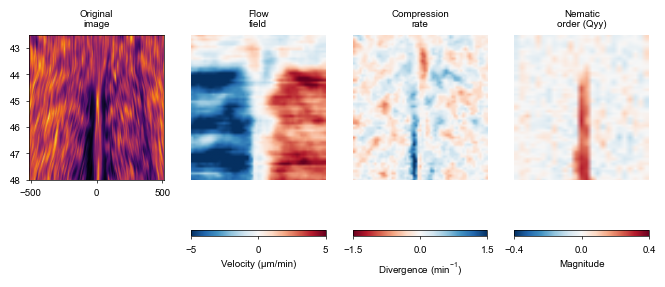

In [17]:
fig, axs = plt.subplots(2,4,figsize=[8,3], gridspec_kw={"height_ratios": [1,0.03]})

caxs = axs[1,:]
# for i in range(0,4):
#     caxs.append(make_axes_locatable(axs[0,i]).append_axes('bottom', size=0.1, pad=0.5, box_aspect=1/10))

# panel_1: raw image
im0 = axs[0,0].imshow(movie_kymo, cmap = 'inferno', vmin = video_vmin, vmax = video_vmax*0.8, interpolation='bilinear', extent=[-512,512,kymo_end_time, kymo_start_time], aspect=200)
caxs[0].set_axis_off()

# panel_2: pivlab
im1 = axs[0,1].imshow(piv_kymo, cmap='RdBu_r', vmin=-piv_vel_levels[-1] *5/8, vmax=piv_vel_levels[-1]*5/8, interpolation='bilinear', extent=[-512,512,kymo_end_time, kymo_start_time], aspect=200)
cb1 = fig.colorbar(im1, cax=caxs[1], orientation='horizontal', label='Velocity (\u03BCm/min)', ticks = [-8*5/8, 0, 8*5/8])

# panel_3: divergence
im2 = axs[0,2].imshow(div_kymo, cmap='RdBu', vmin=div_levels[0], vmax=div_levels[-1], interpolation='bilinear', extent=[-512,512,kymo_end_time, kymo_start_time], aspect=200)
cb2 = fig.colorbar(im2, cax=caxs[2], orientation='horizontal', label='Divergence ($\\mathregular{min^{-1}}$)', ticks = [-1.5, 0, 1.5])

# panel_4: nematic order
im3 = axs[0,3].imshow(q_kymo, cmap='RdBu_r', vmin=-qmag_levels[-1], vmax=qmag_levels[-1], interpolation='bilinear', extent=[-512,512,kymo_end_time, kymo_start_time], aspect=200)
cb3 = fig.colorbar(im3, cax=caxs[3], orientation='horizontal', label='Magnitude', ticks = [-0.4, 0, 0.4])

# stride = 2
# q_x_filtering = np.logical_and(qx[::stride, ::stride]>roi1_x, qx[::stride, ::stride]<roi1_x+1024)
# q_y_filtering = np.logical_and(qy[::stride, ::stride]>roi1_y, qy[::stride, ::stride]<roi1_y+1024)
# q_xy_filtering = np.logical_and(q_x_filtering, q_y_filtering)
# axs[0,3].quiver(qx[::stride, ::stride][q_xy_filtering],
#                 qy[::stride, ::stride][q_xy_filtering],
#                 qanglex_unit[frame][::stride, ::stride][q_xy_filtering],
#                 qangley_unit[frame][::stride, ::stride][q_xy_filtering],
#                 color='black',
#                 scale = 20, width = 0.01, pivot = 'mid', headwidth =3, headlength = 0, headaxislength = 0)

# titles
axs[0,0].set_title('Original\nimage', fontsize=7)
axs[0,1].set_title('Flow\nfield', fontsize=7)
axs[0,2].set_title('Compression\nrate', fontsize=7)
axs[0,3].set_title('Nematic\norder (Qyy)', fontsize=7)

[axs[0, i].set_axis_off() for i in range(1,4)]
[axs[0, i].set_ylim(48, 42.5) for i in range(0,4)]
# [axs[0, i].set_yticks([42,44,46,48]) for i in range(0,4)]
# [axs[1, i].set_axis_off() for i in range(4)]
# [axs[0, i].set_aspect('equal') for i in range(4)]

# ranges
# [axs[0, i].set_xlim(roi1_x, roi1_x+1024) for i in range(4)]
# [axs[0, i].set_ylim(roi1_y+1024, roi1_y) for i in range(4)]

fig.align_labels(axs=caxs)
fig.align_titles()

# plt.savefig(folder_name + '/f' + str(frame) + '.png', dpi=400,pad_inches = 0)
# plt.savefig(folder_name + '/f' + str(frame) + '.png', dpi=500, pad_inches = 0)
plt.savefig('illu_kymo.svg')
plt.show()


In [26]:
video_vmax*0.6


1500.0

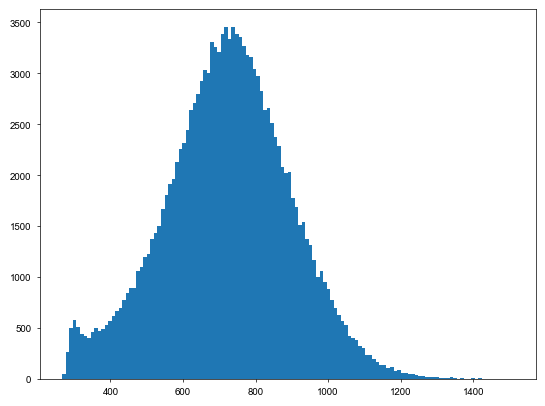

In [25]:
_ = plt.hist(movie_kymo.flatten(), bins=128)

In [28]:
video_vmax

2500

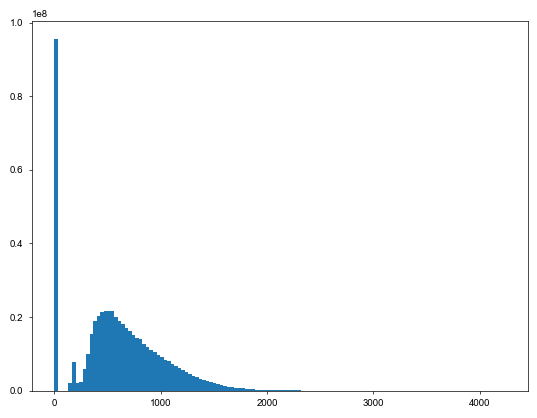

In [27]:
_ = plt.hist(movie.flatten(), bins=128)

In [ ]:
# Create a folder
folder_name = movie_name[:-4] + '_nematic-video-div_middle_svg'
create_folder(folder_name)

# for frame in range(frames-1):
for frame in [34,67,84]:
# for frame in [67]:
        
    print('frame ' + str(frame))

    fig, [[ax, ax1, ax3, ax2], [cax, cax1, cax3, cax2]] = plt.subplots(2,4,figsize=[8,3], gridspec_kw={"height_ratios": [1,0.03]})

    # basic imshow-s
    ax.imshow(movie[frame], cmap='Greys_r', vmin = video_vmin/0.6, vmax = video_vmax/0.6)
    nmod = ax1.imshow(skimage.transform.rescale(-nematic_tensor[frame, 2], 0.5, preserve_range=True), cmap='RdGy_r', interpolation='None', vmin=-0.3, vmax=0.3, extent=[0, xs, ys, 0])
    ax2.imshow(movie[frame], cmap='inferno', vmin = video_vmin, vmax = video_vmax)
    conexp = ax3.imshow(div_total[frame], cmap='RdGy', vmin = -1.5, vmax = 1.5, extent=[0, xs, ys, 0])

    # pivlab

    # method1
    skip=5
    x_filtering = np.logical_and(x[::skip, ::skip]>roi1_x, x[::skip, ::skip]<roi1_x+1024)
    y_filtering = np.logical_and(y[::skip, ::skip]>roi1_y, y[::skip, ::skip]<roi1_y+1024)
    xy_filtering = np.logical_and(x_filtering, y_filtering)
    orientation_cmap = plt.colormaps["hsv"]
    orientation_colors = np.arctan2(v[frame], -u[frame])/(2*np.pi)+0.5
    quiver_kwargs = {'scale':20, 'width':0.012, 'pivot':'mid', 'headwidth':3, 'headlength':5, 'headaxislength':5}
    ax.quiver(x[::skip, ::skip][xy_filtering],y[::skip, ::skip][xy_filtering],
              u[frame][::skip, ::skip][xy_filtering], -v[frame][::skip, ::skip][xy_filtering], 
              color=orientation_cmap(orientation_colors[::skip,::skip][xy_filtering]),
              **quiver_kwargs)
    
    # method2
    # skip=4
    # x_filtering = np.logical_and(x[::skip, ::skip]>roi1_x, x[::skip, ::skip]<roi1_x+1024)
    # y_filtering = np.logical_and(y[::skip, ::skip]>roi1_y, y[::skip, ::skip]<roi1_y+1024)
    # xy_filtering = np.logical_and(x_filtering, y_filtering)
    # orientation_cmap = plt.colormaps["hsv"]
    # orientation_colors = np.arctan2(v[frame], -u[frame])/(2*np.pi)+0.5
    # quiver_kwargs = {'scale':20, 'width':0.012, 'pivot':'mid', 'headwidth':3, 'headlength':5, 'headaxislength':5}

    # orientation_angles = np.arctan2(v[frame], u[frame])
    # v_to_plot = np.sin(orientation_angles) *2
    # u_to_plot = np.cos(orientation_angles) *2

    # ax.quiver(x[::skip, ::skip][xy_filtering], y[::skip, ::skip][xy_filtering],
    #           u_to_plot[::skip, ::skip][xy_filtering], -v_to_plot[::skip, ::skip][xy_filtering],
    #           color='black', #orientation_cmap(orientation_colors[::skip,::skip][xy_filtering]),
    #           **quiver_kwargs)
    
    # vel_to_plot = np.sqrt(v[frame]**2 + u[frame]**2)
    # vel_to_plot = np.swapaxes(vel_to_plot, 0,1)
    # ax.imshow(vel_to_plot, extent=[x.min(), x.max(), y.max(), y.min()], cmap='Blues')

    # nematic order method 2
    # q_angle_x, q_angle_y = nematic_to_vector(nematic_tensor[frame, 2], nematic_tensor[frame, 3])
    # q_angle_mag = np.sqrt(q_angle_x**2 + q_angle_y**2)
    # q_angle_x, q_angle_y = q_angle_x/q_angle_mag, q_angle_y/q_angle_mag
    # q_x, q_y = nematic_tensor[frame, 0], nematic_tensor[frame, 1]

    # ax1.contourf(q_x, q_y, q_angle_mag, cmap='Blues', levels=np.linspace(0,0.4,20), zorder=-5)
    # ax1.quiver(q_x, q_y, q_angle_x, q_angle_y, scale=15, width=0.005, headlength=0, headaxislength=0)
    # ax1.set_aspect('equal')

    # scale bar
    # ax2.plot([1024*0.95 - 20/pixel_size, 1024*0.95], [1024*0.95, 1024*0.95],
    #         color = 'white', linewidth = 2)

    # titles
    ax.set_title('Cortical actin movement', fontsize=12)
    ax1.set_title('Nematic order', fontsize=12)
    ax2.set_title('Original image', fontsize=12)
    ax3.set_title('Compression rate', fontsize=12)

    # time scale
    cax2.text(0.5, 0.5,
                sec_to_min_and_sec((movie_start_time + frame * time_interval/60) *60) +' pf',
                ha='center', va='center')

    [axs.set_axis_off() for axs in [ax, ax1, ax2, ax3]]
    cax2.set_axis_off()

    # color bars
    plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0, 360), cmap="hsv"),
                    cax=cax,  pad=0.001, orientation='horizontal',  label='Orientation (°)$\mathregular{^{ }}$')
    plt.colorbar(nmod, cax=cax1, location ='bottom', pad=0.001, label='Nematic order (AU)$\mathregular{^{ }}$')
    plt.colorbar(conexp, cax=cax3, location ='bottom', pad=0.001, label='Divergence ($\mathregular{min^{-1}}$)')
    # plt.colorbar(conexp, cax=cax3, location ='bottom', pad=0.001, label='Divergence (1/min)')

    cax.set_xticks(np.arange(0, 361, 90)) 
    cax1.set_xticks(np.arange(-0.3, 0.31, 0.3)) 
    cax3.set_xticks(np.arange(-1.5, 2, 1.5)) 

    # [axs.set_ylim((movie_window_xs[frame]+512), (movie_window_xs[frame]-512)) for axs in [ax, ax1, ax2, ax3]]
    #[axs.set_xlim(xs - (moving_window_y+512), xs - (moving_window_y-512)) for axs in [ax, ax1, ax2, ax3]]
    #print(movie_window_xs[frame], moving_window_y)

    [axs.set_xlim(roi1_x, roi1_x+1024) for axs in [ax, ax1, ax2, ax3]]
    [axs.set_ylim(roi1_y+1024, roi1_y) for axs in [ax, ax1, ax2, ax3]]

    fig.align_labels()
    fig.align_titles()

    plt.tight_layout()
    plt.savefig(folder_name + '/f' + str(frame+1) + '.svg')
    plt.show()

In [ ]:
# Create a folder
folder_name = movie_name[:-4] + '_nematic-video-div_middle_svg'
create_folder(folder_name)

# for frame in range(frames-1):
for frame in [34,67,84]:
# for frame in [67]:
        
    print('frame ' + str(frame))

    fig, [[ax, ax1, ax3, ax2], [cax, cax1, cax3, cax2]] = plt.subplots(2,4,figsize=[8,3], gridspec_kw={"height_ratios": [1,0.03]})

    # basic imshow-s
    # ax.imshow(movie[frame], cmap='Greys_r', vmin = video_vmin/0.6, vmax = video_vmax/0.6)
    # nmod = ax1.imshow(skimage.transform.rescale(nematic_tensor[frame], 0.5, preserve_range=True), cmap='RdGy_r', interpolation='None', vmin=-0.3, vmax=0.3, extent=[0, xs, ys, 0])
    ax2.imshow(movie[frame], cmap='inferno', vmin = video_vmin, vmax = video_vmax)
    conexp = ax3.imshow(div_total[frame], cmap='RdGy', vmin = -1.5, vmax = 1.5, extent=[0, xs, ys, 0])

    # pivlab

    # method1
    # skip=5
    # x_filtering = np.logical_and(x[::skip, ::skip]>roi1_x, x[::skip, ::skip]<roi1_x+1024)
    # y_filtering = np.logical_and(y[::skip, ::skip]>roi1_y, y[::skip, ::skip]<roi1_y+1024)
    # xy_filtering = np.logical_and(x_filtering, y_filtering)
    # orientation_cmap = plt.colormaps["hsv"]
    # orientation_colors = np.arctan2(v[frame], -u[frame])/(2*np.pi)+0.5
    # quiver_kwargs = {'scale':20, 'width':0.012, 'pivot':'mid', 'headwidth':3, 'headlength':5, 'headaxislength':5}
    # ax.quiver(x[::skip, ::skip][xy_filtering],y[::skip, ::skip][xy_filtering],
    #           u[frame][::skip, ::skip][xy_filtering], -v[frame][::skip, ::skip][xy_filtering], 
    #           color=orientation_cmap(orientation_colors[::skip,::skip][xy_filtering]),
    #           **quiver_kwargs)
    
    # method2
    skip=4
    x_filtering = np.logical_and(x[::skip, ::skip]>roi1_x, x[::skip, ::skip]<roi1_x+1024)
    y_filtering = np.logical_and(y[::skip, ::skip]>roi1_y, y[::skip, ::skip]<roi1_y+1024)
    xy_filtering = np.logical_and(x_filtering, y_filtering)
    orientation_cmap = plt.colormaps["hsv"]
    orientation_colors = np.arctan2(v[frame], -u[frame])/(2*np.pi)+0.5
    quiver_kwargs = {'scale':20, 'width':0.012, 'pivot':'mid', 'headwidth':3, 'headlength':5, 'headaxislength':5}

    orientation_angles = np.arctan2(v[frame], u[frame])
    v_to_plot = np.sin(orientation_angles) *2
    u_to_plot = np.cos(orientation_angles) *2

    ax.quiver(x[::skip, ::skip][xy_filtering], y[::skip, ::skip][xy_filtering],
              u_to_plot[::skip, ::skip][xy_filtering], -v_to_plot[::skip, ::skip][xy_filtering],
              color='black', #orientation_cmap(orientation_colors[::skip,::skip][xy_filtering]),
              **quiver_kwargs)
    
    vel_to_plot = np.sqrt(v[frame]**2 + u[frame]**2)
    vel_to_plot = np.swapaxes(vel_to_plot, 0,1)
    ax.imshow(vel_to_plot, extent=[x.min(), x.max(), y.max(), y.min()], cmap=new_reds_cmap)

    # nematic order method 2
    q_angle_x, q_angle_y = nematic_to_vector(nematic_tensor[frame, 2], nematic_tensor[frame, 3])
    q_angle_mag = np.sqrt(q_angle_x**2 + q_angle_y**2)
    q_angle_x, q_angle_y = q_angle_x/q_angle_mag, q_angle_y/q_angle_mag
    q_x, q_y = nematic_tensor[frame, 0], nematic_tensor[frame, 1]

    ax1.contourf(q_x, q_y, q_angle_mag, cmap=new_reds_cmap, levels=np.linspace(0,0.4,20), zorder=-5)
    ax1.quiver(q_x, q_y, q_angle_x, q_angle_y, scale=15, width=0.005, headlength=0, headaxislength=0)
    ax1.set_aspect('equal')

    # scale bar
    # ax2.plot([1024*0.95 - 20/pixel_size, 1024*0.95], [1024*0.95, 1024*0.95],
    #         color = 'white', linewidth = 2)

    # titles
    ax.set_title('Cortical actin movement', fontsize=12)
    ax1.set_title('Nematic order', fontsize=12)
    ax2.set_title('Original image', fontsize=12)
    ax3.set_title('Compression rate', fontsize=12)

    # time scale
    cax2.text(0.5, 0.5,
                sec_to_min_and_sec((movie_start_time + frame * time_interval/60) *60) +' pf',
                ha='center', va='center')

    # [axs.set_axis_off() for axs in [ax, ax1, ax2, ax3]]
    cax2.set_axis_off()

    # color bars
    plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0, 360), cmap="hsv"),
                    cax=cax,  pad=0.001, orientation='horizontal',  label='Orientation (°)$\mathregular{^{ }}$')
    # plt.colorbar(nmod, cax=cax1, location ='bottom', pad=0.001, label='Nematic order (AU)$\mathregular{^{ }}$')
    plt.colorbar(conexp, cax=cax3, location ='bottom', pad=0.001, label='Divergence ($\mathregular{min^{-1}}$)')
#     plt.colorbar(conexp, cax=cax3, location ='bottom', pad=0.001, label='Divergence (1/min)')

    cax.set_xticks(np.arange(0, 361, 90)) 
    cax1.set_xticks(np.arange(-0.3, 0.31, 0.3)) 
    cax3.set_xticks(np.arange(-1.5, 2, 1.5)) 

    # [axs.set_ylim((movie_window_xs[frame]+512), (movie_window_xs[frame]-512)) for axs in [ax, ax1, ax2, ax3]]
    #[axs.set_xlim(xs - (moving_window_y+512), xs - (moving_window_y-512)) for axs in [ax, ax1, ax2, ax3]]
    #print(movie_window_xs[frame], moving_window_y)

    [axs.set_xlim(roi1_x, roi1_x+1024) for axs in [ax, ax1, ax2, ax3]]
    [axs.set_ylim(roi1_y+1024, roi1_y) for axs in [ax, ax1, ax2, ax3]]

    fig.align_labels()
    fig.align_titles()

    plt.tight_layout()
    plt.savefig(folder_name + '/f' + str(frame+1) + '.svg')
    plt.show()

### moving window edge

In [ ]:
# how the window moves
a = np.array([[64-1, 1], [84-1, 1]])
b = np.array([50*16, 85*16])
c = np.linalg.solve(a,b)
roi2_ys = np.array([int(np.dot([frame, 1], c)) for frame in range(frames-1)])
print(roi2_ys)
roi2_ys[roi2_ys <= roi1_y] = roi1_y

In [ ]:
# Create a folder
folder_name = movie_name[:-4] + '_nematic-video-div_edge_svg'
create_folder(folder_name)

# for frame in range(frames-1):
for frame in [84]:
# for frame in [67]:
        
    print('frame ' + str(frame))

    fig, [[ax, ax1, ax3, ax2], [cax, cax1, cax3, cax2]] = plt.subplots(2,4,figsize=[8,3], gridspec_kw={"height_ratios": [1,0.03]})

    # basic imshow-s
    ax.imshow(movie[frame], cmap='Greys_r', vmin = video_vmin/0.6, vmax = video_vmax/0.6)
    nmod = ax1.imshow(skimage.transform.rescale(nematic_tensor[frame], 0.5, preserve_range=True), cmap='RdGy_r', interpolation='None', vmin=-0.3, vmax=0.3, extent=[0, xs, ys, 0])
    ax2.imshow(movie[frame], cmap='inferno', vmin = video_vmin, vmax = video_vmax)
    conexp = ax3.imshow(div_total[frame], cmap='RdGy', vmin = -1.5, vmax = 1.5, extent=[0, xs, ys, 0])

    # pivlab
    skip=5

    x_filtering = np.logical_and(x[::skip, ::skip]>roi1_x, x[::skip, ::skip]<roi1_x+1024)
    y_filtering = np.logical_and(y[::skip, ::skip]>roi2_ys[frame], y[::skip, ::skip]<roi2_ys[frame]+1024)
    xy_filtering = np.logical_and(x_filtering, y_filtering)

    
    orientation_cmap = plt.colormaps["hsv"]
    orientation_colors = np.arctan2(v[frame], -u[frame])/(2*np.pi)+0.5
    quiver_kwargs = {'scale':25, 'width':0.01, 'pivot':'mid', 'headwidth':3, 'headlength':5, 'headaxislength':5}
    ax.quiver(x[::skip, ::skip][xy_filtering],y[::skip, ::skip][xy_filtering],
              u[frame][::skip, ::skip][xy_filtering], -v[frame][::skip, ::skip][xy_filtering], 
              color=orientation_cmap(orientation_colors[::skip,::skip][xy_filtering]),
              **quiver_kwargs)


    # scale bar
    # ax2.plot([1024*0.95 - 20/pixel_size, 1024*0.95], [1024*0.95, 1024*0.95],
    #         color = 'white', linewidth = 2)

    # titles
    ax.set_title('Cortical actin movement', fontsize=12)
    ax1.set_title('Nematic order', fontsize=12)
    ax2.set_title('Original image', fontsize=12)
    ax3.set_title('Compression rate', fontsize=12)

    # time scale
    cax2.text(0.5, 0.5,
                sec_to_min_and_sec((movie_start_time + frame * time_interval/60) *60) +' pf',
                ha='center', va='center')

    [axs.set_axis_off() for axs in [ax, ax1, ax2, ax3]]
    cax2.set_axis_off()

    # color bars
    plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0, 360), cmap="hsv"),
                    cax=cax,  pad=0.001, orientation='horizontal',  label='Orientation (°)$\mathregular{^{ }}$')
    plt.colorbar(nmod, cax=cax1, location ='bottom', pad=0.001, label='Nematic order (AU)$\mathregular{^{ }}$')
    plt.colorbar(conexp, cax=cax3, location ='bottom', pad=0.001, label='Divergence ($\mathregular{min^{-1}}$)')
#     plt.colorbar(conexp, cax=cax3, location ='bottom', pad=0.001, label='Divergence (1/min)')

    cax.set_xticks(np.arange(0, 361, 90)) 
    cax1.set_xticks(np.arange(-0.3, 0.31, 0.3)) 
    cax3.set_xticks(np.arange(-1.5, 2, 1.5)) 

    #[axs.set_ylim((movie_window_xs[frame]+512), (movie_window_xs[frame]-512)) for axs in [ax, ax1, ax2, ax3]]
    #[axs.set_xlim(xs - (moving_window_y+512), xs - (moving_window_y-512)) for axs in [ax, ax1, ax2, ax3]]
    #print(movie_window_xs[frame], moving_window_y)

    [axs.set_xlim(roi1_x, roi1_x+1024) for axs in [ax, ax1, ax2, ax3]]
    [axs.set_ylim(roi2_ys[frame]+1024, roi2_ys[frame]) for axs in [ax, ax1, ax2, ax3]]
    print(roi2_ys[frame])

    fig.align_labels()
    fig.align_titles()

    plt.tight_layout()
    plt.savefig(folder_name + '/f' + str(frame+1) + '.svg')
    plt.show()

In [ ]:
Theta.shape

In [ ]:
orientation_cmap = plt.colormaps["hsv"]
orientation_cmap(Theta / (2 * np.pi)).shape

In [ ]:
plt.cm.hsv(Theta / (2 * np.pi)).shape

In [ ]:
emtpy_img = np.ones([1024, 1024])

fig,ax=plt.subplots(figsize=(3,3))
ax.imshow(emtpy_img, cmap='Greys', vmin=0, vmax=2)
theta = np.linspace(0, 2 * np.pi, 12, endpoint = False)
rho, velocity = 150, 5
x, y = rho * np.sin(theta) +512, rho * np.cos(theta)+512
u, v = velocity * np.sin(theta), velocity * np.cos(theta)
orientation_cmap = plt.colormaps["hsv"]
orientation_colors = np.arctan2(v, -u)/(2*np.pi)+0.5

quiver_kwargs = {'scale':25, 'width':0.01, 'pivot':'mid', 'headwidth':3, 'headlength':5, 'headaxislength':5}
ax.quiver(x,y,u,-v,color=orientation_cmap(orientation_colors),
            **quiver_kwargs)
# ax.set_ylim(2, -2)
# ax.set_xlim(-2,2)
plt.savefig('orientation_colorbar2.svg')
plt.show()


In [ ]:

# Set up polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(3,3))

# Define angular and radial grid
theta = np.linspace(0, 2 * np.pi, 1000)
radii = np.linspace(0, 1, 2)  # thin ring (like a color wheel)

# Create meshgrid
Theta, R = np.meshgrid(theta, radii)

# Use theta (angle) as the data to map to colors
Z = Theta  # This will get mapped via colormap

# Plot using pcolormesh and HSV colormap
c = ax.pcolormesh(Theta, R, Z, shading='auto', cmap='hsv', vmin=0, vmax=2 * np.pi)

# Customize ticks and labels
ax.set_yticks([])
ax.set_xticks([])
# ax.set_xticks(np.linspace(0, 2 * np.pi, 8, endpoint=False))
# ax.set_xticklabels([f'{int(np.degrees(t))}°' for t in np.linspace(0, 2 * np.pi, 8, endpoint=False)])
# ax.set_title("HSV Pie Colorbar", va='bottom')

# Optional: tidy up
ax.grid(False)
ax.spines['polar'].set_visible(False)
# plt.savefig('orientation_colorbar.svg')
plt.savefig('orientation_colorbar.png', bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [ ]:
# Create a folder
folder_name = movie_name[:-4] + '_nematic-video-div_middleandedge'
create_folder(folder_name)

for frame in range(frames-1):
# for frame in [34,67,84]:
# for frame in [67]:
# for frame in [100]:
        
    print('frame ' + str(frame))

    fig = plt.figure(figsize=(12,6), layout="constrained")
    spec = fig.add_gridspec(3, 6, width_ratios=[1.6,0.3,1,1,1,1], height_ratios=[1,1,0.05])

    ax = fig.add_subplot(spec[0, 2])
    ax1= fig.add_subplot(spec[0, 3])
    ax3= fig.add_subplot(spec[0, 4])
    ax2= fig.add_subplot(spec[0, 5])

    ax0 = fig.add_subplot(spec[1, 2])
    ax10= fig.add_subplot(spec[1, 3])
    ax30= fig.add_subplot(spec[1, 4])
    ax20= fig.add_subplot(spec[1, 5])

    titley = fig.add_subplot(spec[0, 1])
    titley0 = fig.add_subplot(spec[1, 1])

    cax = fig.add_subplot(spec[2, 2])
    cax1= fig.add_subplot(spec[2, 3])
    cax3= fig.add_subplot(spec[2, 4])
    cax2= fig.add_subplot(spec[2, 5])

    ax_raw_image = fig.add_subplot(spec[:, 0])
    ax_raw_image.imshow(movie[frame], cmap='inferno', vmin = video_vmin, vmax = video_vmax)
    ax_raw_image.set_axis_off()

    roi1_rectangle = mpl.patches.Rectangle( (roi1_x, roi1_y), 1024, 1024, fill=False, clip_on=False, color = 'yellow', lw=2)
    ax_raw_image.add_patch(roi1_rectangle)
    ax_raw_image.text(roi1_x+512, roi1_y-10, 'Middle', rotation='horizontal', va='bottom', ha='center', fontsize=12, color='yellow')

    ## middle

    # basic imshow-s
    ax.imshow(movie[frame], cmap='Greys_r', vmin = video_vmin/0.6, vmax = video_vmax/0.6)
    nmod = ax1.imshow(skimage.transform.rescale(nematic_tensor[frame], 0.5, preserve_range=True), cmap='RdGy_r', interpolation='None', vmin=-0.3, vmax=0.3, extent=[0, xs, ys, 0])
    ax2.imshow(movie[frame], cmap='inferno', vmin = video_vmin, vmax = video_vmax)
    conexp = ax3.imshow(div_total[frame], cmap='RdGy', vmin = -1.5, vmax = 1.5, extent=[0, xs, ys, 0])

    # pivlab

    skip=5

    x_filtering = np.logical_and(x[::skip, ::skip]>roi1_x, x[::skip, ::skip]<roi1_x+1024)
    y_filtering = np.logical_and(y[::skip, ::skip]>roi1_y, y[::skip, ::skip]<roi1_y+1024)
    xy_filtering = np.logical_and(x_filtering, y_filtering)

    
    orientation_cmap = plt.colormaps["hsv"]
    orientation_colors = np.arctan2(v[frame], -u[frame])/(2*np.pi)+0.5
    quiver_kwargs = {'scale':20, 'width':0.012, 'pivot':'mid', 'headwidth':3, 'headlength':5, 'headaxislength':5}
    ax.quiver(x[::skip, ::skip][xy_filtering],y[::skip, ::skip][xy_filtering],
              u[frame][::skip, ::skip][xy_filtering], -v[frame][::skip, ::skip][xy_filtering], 
              color=orientation_cmap(orientation_colors[::skip,::skip][xy_filtering]),
              **quiver_kwargs)

    # scale bar
    # ax2.plot([1024*0.95 - 20/pixel_size, 1024*0.95], [1024*0.95, 1024*0.95],
    #         color = 'white', linewidth = 2)

    # titles
    ax.set_title('Cortical actin movement', fontsize=12)
    ax1.set_title('Nematic order', fontsize=12)
    ax2.set_title('Original image', fontsize=12)
    ax3.set_title('Compression rate', fontsize=12)

    # time scale
    cax2.text(0.5, 0.5,
                sec_to_min_and_sec((movie_start_time + frame * time_interval/60) *60) +' pf',
                ha='center', va='center')

    [axs.set_axis_off() for axs in [titley, ax, ax1, ax2, ax3]]
    cax2.set_axis_off()

    # color bars
    plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0, 360), cmap="hsv"),
                    cax=cax,  pad=0.001, orientation='horizontal',  label='Orientation (°)$\mathregular{^{ }}$')
    plt.colorbar(nmod, cax=cax1, location ='bottom', pad=0.001, label='Nematic order (AU)$\mathregular{^{ }}$')
    plt.colorbar(conexp, cax=cax3, location ='bottom', pad=0.001, label='Divergence ($\mathregular{min^{-1}}$)')
#     plt.colorbar(conexp, cax=cax3, location ='bottom', pad=0.001, label='Divergence (1/min)')

    cax.set_xticks(np.arange(0, 361, 90)) 
    cax1.set_xticks(np.arange(-0.3, 0.31, 0.3)) 
    cax3.set_xticks(np.arange(-1.5, 2, 1.5)) 

    #[axs.set_ylim((movie_window_xs[frame]+512), (movie_window_xs[frame]-512)) for axs in [ax, ax1, ax2, ax3]]
    #[axs.set_xlim(xs - (moving_window_y+512), xs - (moving_window_y-512)) for axs in [ax, ax1, ax2, ax3]]
    #print(movie_window_xs[frame], moving_window_y)

    [axs.set_xlim(roi1_x, roi1_x+1024) for axs in [ax, ax1, ax2, ax3]]
    [axs.set_ylim(roi1_y+1024, roi1_y) for axs in [ax, ax1, ax2, ax3]]

    if roi1_y != roi2_ys[frame] & roi2_ys[frame]<ys:

        if roi2_ys[frame]+1024 <= ys:
            roi2_rectangle_height = 1024
        else:
            roi2_rectangle_height = ys - roi2_ys[frame]
            

        roi2_rectangle = mpl.patches.Rectangle( (roi1_x, roi2_ys[frame]), 1024, roi2_rectangle_height, fill=False, clip_on=False, color = 'cyan', lw=2)
        ax_raw_image.add_patch(roi2_rectangle)
        ax_raw_image.text(roi1_x+512, roi2_ys[frame]-10, 'Edge', rotation='horizontal', va='bottom', ha='center', fontsize=12, color='cyan')

        ## edge

        # basic imshow-s
        ax0.imshow(movie[frame], cmap='Greys_r', vmin = video_vmin/0.6, vmax = video_vmax/0.6)
        nmod = ax10.imshow(skimage.transform.rescale(nematic_tensor[frame], 0.5, preserve_range=True), cmap='RdGy_r', interpolation='None', vmin=-0.3, vmax=0.3, extent=[0, xs, ys, 0])
        ax20.imshow(movie[frame], cmap='inferno', vmin = video_vmin, vmax = video_vmax)
        conexp = ax30.imshow(div_total[frame], cmap='RdGy', vmin = -1.5, vmax = 1.5, extent=[0, xs, ys, 0])

        # pivlab
        skip=5

        x_filtering = np.logical_and(x[::skip, ::skip]>roi1_x, x[::skip, ::skip]<roi1_x+1024)
        y_filtering = np.logical_and(y[::skip, ::skip]>roi2_ys[frame], y[::skip, ::skip]<roi2_ys[frame]+1024)
        xy_filtering = np.logical_and(x_filtering, y_filtering)

        
        orientation_cmap = plt.colormaps["hsv"]
        orientation_colors = np.arctan2(v[frame], -u[frame])/(2*np.pi)+0.5
        quiver_kwargs = {'scale':25, 'width':0.01, 'pivot':'mid', 'headwidth':3, 'headlength':5, 'headaxislength':5}
        ax0.quiver(x[::skip, ::skip][xy_filtering],y[::skip, ::skip][xy_filtering],
                u[frame][::skip, ::skip][xy_filtering], -v[frame][::skip, ::skip][xy_filtering], 
                color=orientation_cmap(orientation_colors[::skip,::skip][xy_filtering]),
                **quiver_kwargs)


    # time scale

    [axs.set_axis_off() for axs in [titley0, ax0, ax10, ax20, ax30]]
    cax2.set_axis_off()

    # color bars
    # plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0, 360), cmap="hsv"),
    #                 cax=cax,  pad=0.001, orientation='horizontal',  label='Orientation (°)$\mathregular{^{ }}$')
    # plt.colorbar(nmod, cax=cax1, location ='bottom', pad=0.001, label='Nematic order (AU)$\mathregular{^{ }}$')
    # plt.colorbar(conexp, cax=cax3, location ='bottom', pad=0.001, label='Divergence ($\mathregular{min^{-1}}$)')
#     plt.colorbar(conexp, cax=cax3, location ='bottom', pad=0.001, label='Divergence (1/min)')

    # cax.set_xticks(np.arange(0, 361, 90)) 
    # cax1.set_xticks(np.arange(-0.3, 0.31, 0.3)) 
    # cax3.set_xticks(np.arange(-1.5, 2, 1.5)) 

    #[axs.set_ylim((movie_window_xs[frame]+512), (movie_window_xs[frame]-512)) for axs in [ax, ax1, ax2, ax3]]
    #[axs.set_xlim(xs - (moving_window_y+512), xs - (moving_window_y-512)) for axs in [ax, ax1, ax2, ax3]]
    #print(movie_window_xs[frame], moving_window_y)

    [axs.set_xlim(roi1_x, roi1_x+1024) for axs in [ax0, ax10, ax20, ax30]]
    [axs.set_ylim(roi2_ys[frame]+1024, roi2_ys[frame]) for axs in [ax0, ax10, ax20, ax30]]

    titley.text(0.5,0.5,'Middle', rotation='vertical', va='center', ha='center')
    titley0.text(0.5,0.5,'Edge',  rotation='vertical', va='center', ha='center')

    
    fig.align_labels()
    fig.align_titles()

    # plt.tight_layout()
    plt.savefig(folder_name + '/f' + str(frame+1) + '.png', dpi=400,pad_inches = 0)
    plt.show()

In [ ]:
###kymograph



In [ ]:
np.linspace(0, 1, 256)

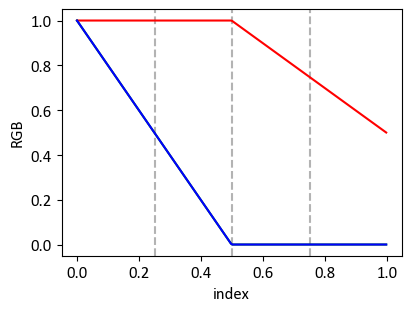

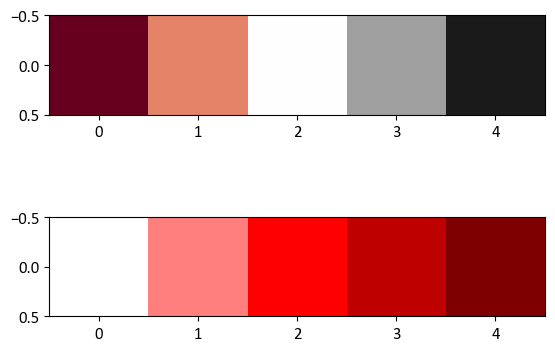

In [14]:
#create a lut for flow kymo

from matplotlib.colors import LinearSegmentedColormap

howgrey = 0.75
cdict = {'red':   [[0.0,  1.0, 1.0],
                   [0.5,  1.0, 1.0],
                   [1.0,  0.5, 1.0]],
         'green': [[0.0,  1.0, 1.0],
                   [0.5,  0.0, 0.0],
                   [1.0,  0.0, 0.0]],
         'blue':  [[0.0,  1.0, 1.0],
                   [0.5,  0.0, 0.0],
                   [1.0,  0.0, 0.0]]}
cmap_reds = LinearSegmentedColormap('testCmap', segmentdata=cdict, N=256)

rgba = cmap_reds(np.linspace(0,1,256))

fig, ax = plt.subplots(figsize=(4, 3), layout='constrained')
col = ['r', 'g', 'b']
for xx in [0.25, 0.5, 0.75]:
    ax.axvline(xx, color='0.7', linestyle='--')
for i in range(3):
    ax.plot(np.arange(256)/256, rgba[:, i], color=col[i])
ax.set_xlabel('index')
ax.set_ylabel('RGB')
plt.show()

data = [[1, 2, 3, 4, 5]]
fig, (ax1, ax2) = plt.subplots(nrows=2)
ax1.imshow(data, cmap='RdGy')
ax2.imshow(data, cmap=cmap_reds)
plt.show()

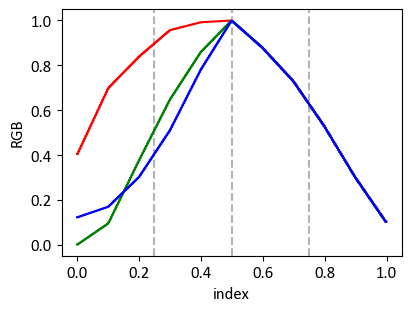

In [15]:
rdgy_colormap = orientation_cmap = plt.colormaps["RdGy"]

rgba = rdgy_colormap(np.linspace(0,1,1024))

fig, ax = plt.subplots(figsize=(4, 3), layout='constrained')
col = ['r', 'g', 'b']
for xx in [0.25, 0.5, 0.75]:
    ax.axvline(xx, color='0.7', linestyle='--')
for i in range(3):
    ax.plot(np.arange(1024)/1024, rgba[:, i], color=col[i])
ax.set_xlabel('index')
ax.set_ylabel('RGB')
plt.show()



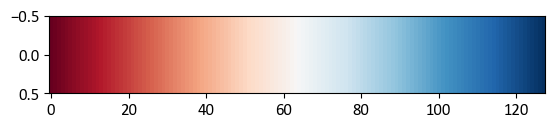

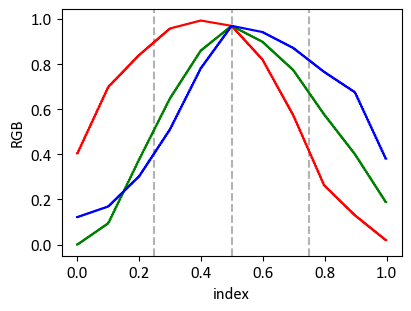

In [128]:
rdgy_colormap = orientation_cmap = plt.colormaps["RdBu"]
plt.imshow([np.arange(128)], aspect=20, cmap=rdgy_colormap)
plt.show()

rgba = rdgy_colormap(np.linspace(0,1,1024))

fig, ax = plt.subplots(figsize=(4, 3), layout='constrained')
col = ['r', 'g', 'b']
for xx in [0.25, 0.5, 0.75]:
    ax.axvline(xx, color='0.7', linestyle='--')
for i in range(3):
    ax.plot(np.arange(1024)/1024, rgba[:, i], color=col[i])
ax.set_xlabel('index')
ax.set_ylabel('RGB')
plt.show()


In [130]:
np.linspace(0,1,5)

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

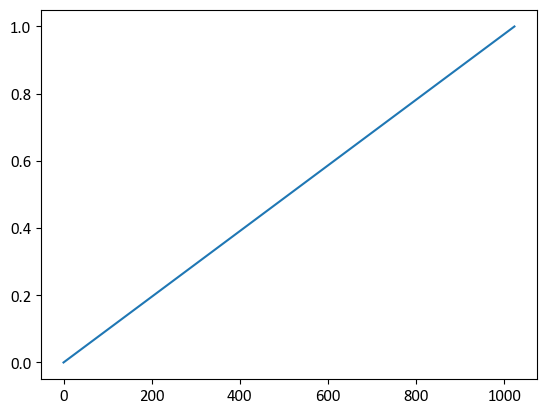

In [ ]:
a = np.linspace(0,1,1024)

plt.plot(a)

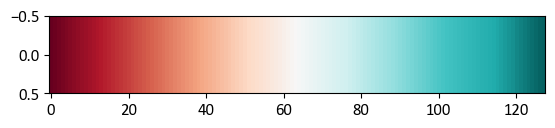

In [149]:
rdcn_cmap = mpl.colormaps['RdBu'](np.linspace(0,1,2049))
rdcn_cmap[1024:,1] = rdcn_cmap[1024:,2]
rdcn_cmap = mpl.colors.ListedColormap(rdcn_cmap)
plt.imshow([np.arange(128)], aspect=20, cmap=rdcn_cmap)
plt.show()

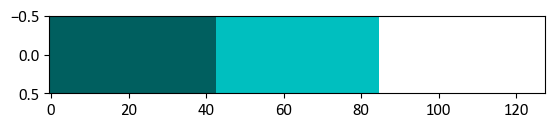

In [127]:
cnrd_cmap = mpl.colors.ListedColormap([[0, 0.75*0.5, 0.75*0.5], [0, 0.75, 0.75], [1,1,1]])
plt.imshow([np.arange(128)], aspect=20, cmap=cnrd_cmap)
plt.show()

In [40]:
mpl.colormaps['RdGy'](np.linspace(0.5,0,1024)).shape

(1024, 4)